## FeasibleRRT&TimeMinimumOptimization
This notebook is to combine the Feasible RRT and time minimum optimization to plan a fastest trajectory in position-time space. First, plan a coarse trajectory through Feasible RRT which satisfies the kinematic limitations. Second, optimize the trajectory in order to reduce the time.

### Feasible RRT
The main idea is to correct the branch so that every branch added is kinematically admissible. We set the limitations of the following physical terms: curvature $\kappa$, longitude velocity $v^s$, longitude acceleration $a^s$ and lateral acceleration $a^l$. Figure 1 shows the definitions. Figure 2 shows the correcting procedure via adjusting the time interval. Figure 3 shows the workflow of Feasible RRT and Figure 4 shows the result. The black line is the target position. The blue geometries are trajectories of other vehicles. Yellow region is the space between two lane lines. Green tree is the RRT and red line is the coarse trajectory.
<img src = "Images/ConvexRegion1.png" width = 500>
<img src = "Images/ConvexRegion2.png" width = 500>
<img src = "Images/ConvexRegion3.png" width = 400>
<img src = "Images/ConvexRegion4.png" width = 400>

### Time Minimum Optimization

The main idea is to create renewing feasible region and use a cost function to minimize the time. Set the motion or trajectory point as $(x,y,t) = (p,t)$. Denote the target position is $p_f$. The cost function is 

$$
\begin{aligned}
\min_{p_i}& J=-\frac{1}{\sum_{i=0}^{n-1}|p_i-p_f|^2+1}\\
s.t.&p_i \in \Phi_i, \forall i\\
& AP\le B\\
& P = \begin{bmatrix}p_0,p_1,...,p_{n-1}\end{bmatrix}
\end{aligned}
$$


The procedure to calculate $\Phi_i$ is shown in Figure 5. And the result is shown in Figure 6.
<img src = "Images/ConvexRegion5.png" width = 700>
<img src = "Images/ConvexRegion6.png" width = 900>

## Docs

This notebook is aimed to record what I have learned during the spare time of my work. 

### lane model

- **Background:** Normal models to represent the lane, for example, 3-order polynomial curve and 3-order spiral curve, have their drawbacks when predicting the future lane (it should be noticed B-spline and NURBS curves can only used as fitting). They are all good at fitting. Giving several points, they can generate a smooth and satisfying curve which is close to the giving points. However, when predicting the future lane, this model will encounter unexpected distortion. For example, the curvature will be extremely big or even the kink may occur. The reason is that the fitting only takes the giving points into consideration and the high order will result in uncontrollable extremes. Using the fitting coefficients to predict the future lane is not a good choice in reality. In some cases, we require a long lane along the car direction but the sensor and the map can only give a short but realiable lane. Thus, future lane prediction is essential.
- **Lane model:** The lane itself has some models when designing. Lane can be divided into three types: *straight*, *circular*, *adjustment curve*. The curvatures of *straight* and *circular* are constants. And the curvature of *adjustment curve* is $\kappa(s) = ks + b$, $s$ is the length of the lane. Thus, we can use 1-order spiral line to fit and predict the lane.
- **Polyline fitting:** Polyline fitting is a complex work. Currently, enumeration is the reliable way to solve when there are only two lines to fitting.
- **Extra consideration:** When predicting a long future lane, state transimission between three types of lane should be considered. For example, when the type of latter fitting lane is *adjustment* and the curvature is decreasing, the future lane is more likely to be *adjustment* and then *straight*. So state machine should be utilized. Another problem is the constraint and preferred value. They are really important to predict a reasonable future lane. For example, the maximum centripetal acceleration $a_{max}$ is $3 m/s^2$ according to EU regulation to autopilot where driving comfort is considered. And we can get current velocity of the vehicle $v$ so the maximum curvature $\kappa_{max}$ is $a_{max}/v^2$. Thus, when predicting a *adjustment curve*, the curvature of the lane is more likely to be less than $\kappa_{max}$. And the sequent lane type is more likely to be *circular* and its curvature can be set to $\kappa_{max}$. This kind of setting is reasonable. Another setting worth consideration is the length of each type of the lane. According to regulations, the recommended length ratio between *straight*/*circular* : *adjustment* : *straight*/*circular* = 1:1:1. On the other hand, the minimal length of the *adjustment* is $3v$, which means the driver should be given three seconds to pass the *adjustment*.

### motion planning in autopilot

Motion planning in autopilot can be divided into several steps in the real application. First step is to plan a collision-free and smooth reference path. Second step is to plan the lateral and longitudinal trajectory. Third step is to control the vehicle to follow the trajectory.
- **Reference path planning:** Reference path planning is defined as that giving the environment and ego vehicle conditions, planning a optimal reference path. The path should be collision-free, smooth, satisfying constraints such as maximum curvature. Generally, path planning problem can be solved by sampling methods in the field of robotics, for example, A*, RRT and so on. Of course, dynamics of the vehicle or robot attracts more and more attention in academia. Hybrid A*, kinodynamics RRT* and other algorithms attempt to plan a reference path considering the dynamics. The main idea is to plan the next point within the reachable space of the current state iterably. They reduce the possibility of the conflicts between reference path planning and trajectory planning when they are planned seperately. In the field of autopilot, due to real time demand, sampling methods with less consideration on dynamics are used in the real world. 
 - Along the center line of the lane, establish the $s-l$ coordinates. $s$ means the length of the center line, $l$ means the distance away from the center line (Frenet Coordinates). So we can divide the lane band area into patches along the $s$ and $l$, and get a set of candidates for destination (the center of each patch, which we can denote as a vertex). Then we can connect the current position of the vehicle and one of the vertexes and generate a candidate of the reference path. Finally, we can evaluate them and choose a best one. In some senarios, just using the center line of the lane as the reference path is an option. However, the path of the vehicle driven by human is not along with the center line of the lane, especially when turning. So it is necessay to plan a reference path for autopilot.
   - **Reference path model:** The reference path can be modeled as 3-5 order polynomial curve, 3 or 5 order spiral curve, trigonomatric curve, tanh curve and so on. The most commom curve is polynomial curve but in some extreme cases, the curvature can be extreme. More stable models are tanh curve and spiral curve. Spiral curve is stable for the vehicle because it directly controls the curvature and the generated path is just like the path calculated by bi-cycle model of the vehicle. It conforms to kinematics of the vehicle.
   - **Reference path evaluation:** The evaluation of the reference path can be the sum of the deviation from the center line of the lane, distance from the obstacles, the kappa of the path (or the accumulated absolute change of the heading angle) and so on. The weight between different evaluation criterias can be different according to different senarios, for example, stop or vehicle following. The dimensionality between them may cause problems. So a transverse qualitative evaluation is formed. It evaluates each term for all the candidate path and then gives them a qualitative evaluation like "excellent", "good" and "bad". This way is a good option.
 - Different from the former one, to produce a more complex reference path, lattice planner will form a series lattices of the position $l_j(s_i)$ along the center line, and then choose one lattice for each $s_i$, and finally smooth these points. It can handle a more complex path planning problem in a clustered environment. Of course, it will cost more resources. The common search method is **dynamic programming**. Except from searching in the 2D position space, a more complex form is searching in a higher-dimensional space including time, curvature, velocity, acceleration. And parallel computation plays an important role in the real application. It should be noticed that when taking the dynamic and kinamatic constaints into consideration, the search space will shrink. There is a new idea that if we construst the moving obstacle into the search space, the search space will shrink further. One good idea is that this way will solve the reference path planning and trajectory optimization simutaneously. 
 - In the real application, reference path can be planned offline when there is HD map or other resources so it can be solved with more complex consideration.
- **Trajectory planning:** In the field of robotics, trajectory planning may be called as trajectory optimization. Different from the general trajectory optimization problem in the field of robotics, trajectory planning problem in autopilot can be divided into longitudinal speed planning and lateral path planning. In this way, the dimension of the problem can be reduced. Each sub problem plays different roles. The longitudinal speed planning is to plan the velocity in the Frenet coordinate system $s-l$ of the reference path. The main aim is to plan an optimal trajectory to reduce the time, improve the comfort of the passengers, etc. The lateral path planning is to plan the $l(s)$ to avoid the moving or static obstacles. When the reference path is planned offline, the unexpected obstacles may blocked it. For example, there is an accident in the way. When it is planned online using simple sampling methods, the moving obstacles with uncertain behavior prediction may require the vehicle to react in time. 
 - **Longitudinal speed planning:** In the real application of autopilot, behavior decision module will provide a tag to help with the longitudinal speed planning which will limit the search space. Generally, longitudinal speed planning is an optimization problem. In the Frenet coordinate system, *ST* graph of the reference path of the ego vehicle can be formulated. *ST* graph is the relation between time and coordinate *s*. A trajectory is a curve in the graph. Giving the predicted trajectory of the other vehicles and their occupied boxes, we can draw their occupation in the *ST* graph where the trajectory of ego vehicle should not pass. In one common situation, the curve can pass upper or down the occupation. The tag mentioned before will provide whether to decelerate and wait the other vehicle to pass first. In this way, the planning space will be shrinked. 
   - **Objective:** The objective is to minimize the longitudinal acceleration $\ddot s(t)$ and jerk $\dddot s(t)$, circular acceleration $\dot s(t)^2 \kappa (s)$ and the time used. Different from other trajectory optimization problem, the acceleration, jerk and other limitations are not constraints any more. They are objectives to ensure the driving comfort. 
   - **Constraint:** The limitation for velocity, acceleration and so on. They are nolinear.
   - **Method:** Speed profile can be modeled as a function of the time $t$ or $s$. Polynomial curve is one of the most common form. Giving the initial state and the final state, the coefficients can be calculated. The remaining uncertain variable is the final state of the velocity. Sampling the final state of the velocity among the velocity reachable range is a method. And calculate their costs and choose the best one with minimal cost. This kind of method is not reliable. First, polynomial curve only with the boundary constraints may have unexpected and extreme distortion in the middle. Second, sampling may not always provide a feasible solution when *ST* graph is complex due to the curve model. Recently, piece-wise optimization form is formed. It discretizes the $s(t)$ and regards discretized $s(t)$, $\dot s(t)$, $\ddot s(t)$, $\dddot s(t)$ and discretized step $\Delta s$ or $\Delta t$. In this way, the complex problem can be always solved. It should be noticed that we should add the end state evaluation into the objective/cost function. When discretized by $\Delta t$, another consideration is how to add the time into the objective function. An alternative is to generate the ideal reference speed profile, for example, the upper bound in the *ST* graph (considering constraints but no obstacles), and let the $\dot s(t)$ track it. A more direct way is to minimize $\Delta t$. The reason why I haven't seen a paper used this way may be that it is hard to tune the weight. But I am not sure because I think it may not be very hard. When discretized by $\Delta s$, it is hard to formulate the acceleration, jerk, etc. They will add more nolinearity to the optimization problem. This area remains a great room to explore.
  - **Lateral planning:** The main of lateral planning is to avoid the moving and unexpected obstacles. It actually is similar to reference path planning. So similar methods can be used, like sampling or lattice planner. Here I want to introduce optimization methods. Giving a reference path, we can transform the lateral planning problem into function design problem or optimal control problem of desgining the lateral distance from the reference path, $l(s)$. Discretize $l(s)$ by $\Delta s$ and we can get an optimization problem. First, define the boundary of $l(s_i)$. The strategy can be diverse. Simple one may be beam search. From my point of view, sampling method like RRT with simplification treatment can be utilized for the real-time application. Second, we can form the constrained optimization problem. Through some linearization, it can be transfered into a QP problem. The initial state can be set as zero, which means lateral path is exactly reference path. 
  - **PS:**
    - **Smooth reference path:** In the real application, the reference path is represented as points. We should interpolate or smooth it before trajectory planning. The reasons are diverse. One reason is that coordinate transform between Cartisian and Frenet coordinates requires accurate curve length, curvature and other information. Smooth strategy can be solved as interpolation problem. However, commom interpolation method like polynomial, spiral curve, can cause uncontrollable distortion. It can also be solved by optimization problems which is more general and controllable. However, I think the weight is hard to tune and not general for any cases.
    - **Coupled planning:** Currently, longitudinal speed planning and lateral planning are seperate. It limits the possibility of reaching global optimization and in some serious cases, seperate planning can not plan a feasible trajectory. In the field of robotics, trajectory planning is often solved without seperating. The reason *I think* may be that it is hard to solve it in the real-time application and driving senarios limit its search space so sperate planning can always find a feasible solution. In the real application, we want to always find a feasible solution and its optimality can be sacrified. But coupled planning is the future direction because it can provide a more comfort trajectory for human.

## The rest of the notebook
I will realize and test some algorithms. If codes grow large, I may create another notebook to store and test.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
plt.rcParams['figure.figsize'] = (9,9)
import scipy.optimize as optimize
import scipy

### Create lane model 
start time: 11:00 pm, 08/12

In [2]:
## create a lane based on lane model
class traj_pt:
    def __init__(self, x = 0, y = 0, theta = 0, kappa = 0, s = 0):
        self.x = x
        self.y = y
        self.theta = theta
        self.kappa = kappa
        self.s = s
        

In [3]:
def cal_path_from_kappa(kappa_fun, x0,y0,theta0,kappa0, s0,ds,N):
    x = x0
    y = y0
    theta = theta0
    kappa = kappa0
    s = s0
    x_set = [x]
    y_set = [y]
    theta_set = [theta]
    kappa_set = [kappa]
    s_set = [s]
    for i in range(N):
        s += ds
        kappa = kappa_fun(s)
        theta += ds * kappa
        x += ds * np.cos(theta)
        y += ds * np.sin(theta)
        x_set.append(x)
        y_set.append(y)
        theta_set.append(theta)
        kappa_set.append(kappa)
        s_set.append(s)
    return x_set, y_set, theta_set, kappa_set, s_set
    

In [4]:
def poly_fun(c, x):
    y = 0
    for i in range(len(c)):
        y += x**i*c[i]
    return y

class lane_kappa_model:
    def __init__(self, co_set, co_s_set):
        self.co_set = co_set
        self.co_s_set = co_s_set
    def cal_kappa(self, s):
        for i in range(len(self.co_s_set)):
            if s >= self.co_s_set[i][0] and s < self.co_s_set[i][1]:
                return poly_fun(self.co_set[i], s - self.co_s_set[i][0])
        print('out of lane. s :',s)
        return None
    
class trajectory:
    def __init__(self):
        self.x_set = []
        self.y_set = []
        self.theta_set = []
        self.kappa_set = []
        self.s_set = []
        self.t_set = []
    def set_value(self, x_set = [], y_set =[], theta_set = [], kappa_set = [], s_set = [], t_set = []):
        if x_set is not []:
            self.x_set = x_set
        if y_set is not []:
            self.y_set = y_set
        if theta_set is not []:
            self.theta_set = theta_set
        if kappa_set is not []:
            self.kappa_set = kappa_set
        if s_set is not []:
            self.s_set = s_set
        if t_set is not []:
            self.t_set = t_set

<IPython.core.display.Javascript object>


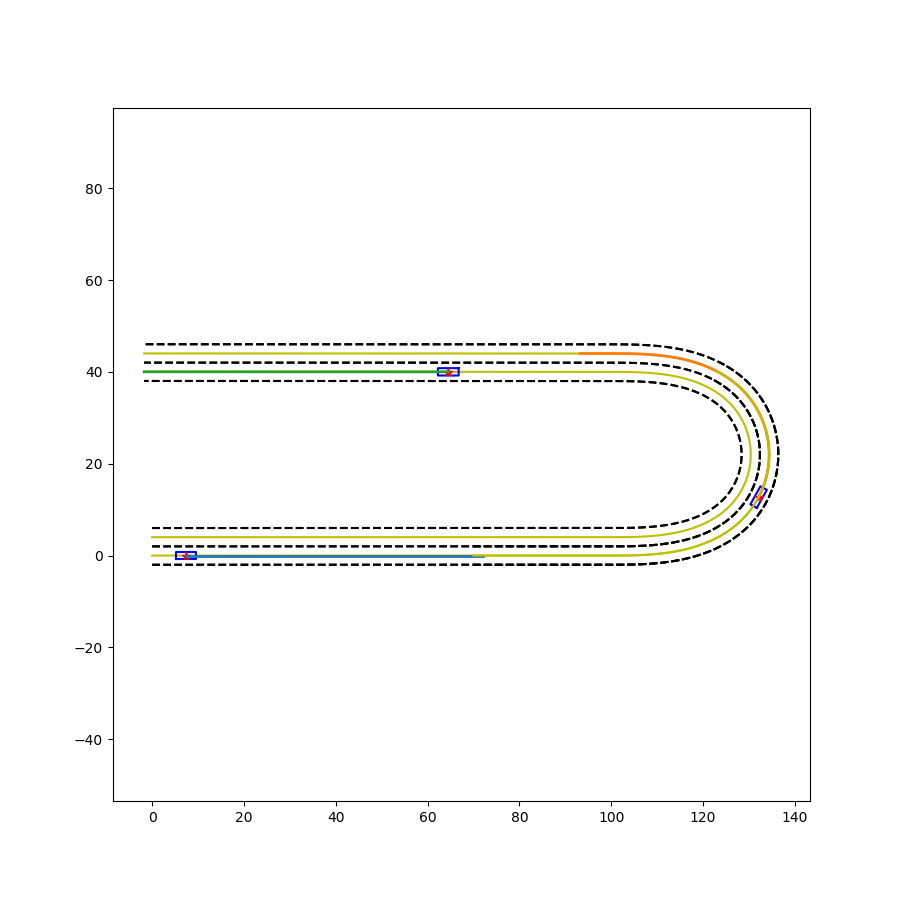

In [5]:
x0 = 0
y0 = 0
theta0 = 0
kappa0 = 0
s0 = 0
ds = 1
N = 390
lane_len1 = 100
lane_radius = 20
lane_angle = np.pi/2
lane_len2 = 100
curve_len = lane_radius * lane_angle
adjust_len = curve_len

co_lane = [0, None, 1/lane_radius, None, 0]
co_s_lane = [lane_len1, adjust_len, curve_len,adjust_len,lane_len2]


co_set = []
co_s_set = []

for i in range(5):
    if i == 0:
        co_s_set.append([0, co_s_lane[i]])
    else:
        co_s_set.append([co_s_set[-1][1], co_s_set[-1][1] + co_s_lane[i]])
    if co_lane[i] is None:
        co_set.append([co_lane[i-1],(co_lane[i+1] - co_lane[i-1])/co_s_lane[i]])
    else:
        co_set.append([co_lane[i],0])
        
N = int(co_s_set[-1][1]/ds)
        
# lane_kappa = lane_kappa_model([[0,0],[0,0.0001],[0.01, 0], [0.01,-0.0001],[0,0]], [[0,100],[100,200],[200,300],[300,400],[400,500]])
lane_kappa = lane_kappa_model(co_set,co_s_set)
x_set, y_set, theta_set, kappa_set, s_set = cal_path_from_kappa(lane_kappa.cal_kappa, x0,y0,theta0,kappa0, s0,ds,N)

mid_lane = trajectory()
inner_lane = trajectory()
outer_lane = trajectory()
lane_width = 4
mid_lane.set_value(x_set, y_set, theta_set, kappa_set, s_set)

inner_lane2 = trajectory()
mid_lane2 = trajectory()


for i in range(len(mid_lane.x_set)):
    x = mid_lane.x_set[i]
    y = mid_lane.y_set[i]
    theta = mid_lane.theta_set[i]
    inner_x = x + lane_width / 2 * np.cos(theta + np.pi/2)
    inner_y = y + lane_width / 2 * np.sin(theta + np.pi/2)
    outer_x = x + lane_width / 2 * np.cos(theta - np.pi/2)
    outer_y = y + lane_width / 2 * np.sin(theta - np.pi/2)
    inner_lane.x_set.append(inner_x)
    inner_lane.y_set.append(inner_y)
    outer_lane.x_set.append(outer_x)
    outer_lane.y_set.append(outer_y)
    
    inner_x2 = x + 3 * lane_width / 2 * np.cos(theta + np.pi/2)
    inner_y2 = y + 3 * lane_width / 2 * np.sin(theta + np.pi/2)
    x2 = x + lane_width * np.cos(theta + np.pi/2)
    y2 = y + lane_width * np.sin(theta + np.pi/2)
    
    inner_lane2.x_set.append(inner_x2)
    inner_lane2.y_set.append(inner_y2)
    mid_lane2.x_set.append(x2)
    mid_lane2.y_set.append(y2)
    
    



plt.plot(mid_lane.x_set, mid_lane.y_set,'y-')
plt.plot(mid_lane2.x_set, mid_lane2.y_set,'y-')
plt.plot(inner_lane.x_set, inner_lane.y_set, 'k--')
plt.plot(inner_lane2.x_set, inner_lane2.y_set, 'k--')
plt.plot(outer_lane.x_set, outer_lane.y_set,'k--')


plt.axis('equal')
plt.show()

### simulate trajectories of the vehicles
start time: 11:04pm, 08/12

In [6]:
class vehicle:
    def __init__(self, v_range = [0,0], s_range = [0,0]):
        self.v = np.random.random()*(v_range[1]-v_range[0]) + v_range[0]
        self.s = np.random.random()*(s_range[1]-s_range[0]) + s_range[0]
        self.laneId = np.random.randint(2)
        self.xy = [None,None]
        self.sl = [self.s,None]
        self.s_base_index = 0
        self.theta = None
        self.ifChangeLane = np.random.randint(2)
        self.trajectory = trajectory()
        
    def cal_self_pos(self, baseLane):
        if self.laneId == 0:
            self.sl[1] = 0
        else:
            self.sl[1] = lane_width
        for i in range(len(baseLane.s_set) - 1):
            if (self.s >= baseLane.s_set[i]) and (self.s < baseLane.s_set[i+1]):
                temp_x = baseLane.x_set[i] + (baseLane.x_set[i+1] - baseLane.x_set[i]) * (self.s - baseLane.s_set[i]) / (baseLane.s_set[i+1] - baseLane.s_set[i])
                temp_y = baseLane.y_set[i] + (baseLane.y_set[i+1] - baseLane.y_set[i]) * (self.s - baseLane.s_set[i]) / (baseLane.s_set[i+1] - baseLane.s_set[i])
                temp_theta = baseLane.theta_set[i] + (baseLane.theta_set[i+1] - baseLane.theta_set[i]) * (self.s - baseLane.s_set[i]) / (baseLane.s_set[i+1] - baseLane.s_set[i])
                self.s_base_index = i
                break
        self.xy[0] = temp_x + self.sl[1] * np.cos(temp_theta + np.pi/2)
        self.xy[1] = temp_y + self.sl[1] * np.sin(temp_theta + np.pi/2)
        self.theta = temp_theta
        
    def cal_traj(self, baseLane, trajLen, changeLaneTime = 3):
        if self.ifChangeLane == 0:
            temp_x_set = []
            temp_y_set = []
            sumS = 0
            temp_x = self.xy[0]
            temp_y = self.xy[1]
            temp_x_set.append(temp_x)
            temp_y_set.append(temp_y)
            if (self.s_base_index + 1) >= len(baseLane.x_set):
                return
            for i in range(self.s_base_index + 1, len(baseLane.x_set)):
                new_x = baseLane.x_set[i] + self.sl[1] * np.cos(baseLane.theta_set[i] + np.pi/2)
                new_y = baseLane.y_set[i] + self.sl[1] * np.sin(baseLane.theta_set[i] + np.pi/2)
                sumS += ((new_x - temp_x)**2 + (new_y - temp_y)**2)**0.5
                temp_x = new_x
                temp_y = new_y
                if sumS > trajLen:
                    break
                else:
                    temp_x_set.append(new_x)
                    temp_y_set.append(new_y)
            self.trajectory.set_value(x_set=temp_x_set, y_set=temp_y_set)
        else:
            changeLaneS = self.v * changeLaneTime
            if self.laneId == 0:
                targetL = lane_width
            else:
                targetL = 0
            ls = self.sl[1]
            le = targetL
            se = changeLaneS
            A = np.asarray([[1,0,0,0],[0,1,0,0],[1,se,se**2,se**3],[0,1,2*se,3*se**2]])
            b = np.asarray([[ls],[0],[le],[0]])
            c = np.linalg.inv(A).dot(b)

            temp_x_set = []
            temp_y_set = []
            sumS = 0
            temp_x = self.xy[0]
            temp_y = self.xy[1]
            temp_x_set.append(temp_x)
            temp_y_set.append(temp_y)

            for i in range(self.s_base_index + 1, len(baseLane.x_set)):
                temp_s = baseLane.s_set[i] - self.sl[0]
                if temp_s < se:
                    temp_l = np.sum([c[i,0]*temp_s**i for i in range(4)])
                else:
                    temp_l = le
                new_x = baseLane.x_set[i] + temp_l * np.cos(baseLane.theta_set[i] + np.pi/2)
                new_y = baseLane.y_set[i] + temp_l * np.sin(baseLane.theta_set[i] + np.pi/2)
                sumS += ((new_x - temp_x)**2 + (new_y - temp_y)**2)**0.5
                temp_x = new_x
                temp_y = new_y
                if sumS > trajLen:
                    break
                else:
                    temp_x_set.append(new_x)
                    temp_y_set.append(new_y)
            self.trajectory.set_value(x_set=temp_x_set, y_set=temp_y_set)
        
            
                    
            
            
                
        




In [7]:
def box_plot_pts(center, size, angle):
    pts = [[-size[0], -size[1]],[size[0], -size[1]],[size[0],size[1]],[-size[0],size[1]],[-size[0],-size[1]]]
    pts = np.asarray(pts).transpose() / 2
    R = [[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]] 
    R = np.asarray(R)
    return R.dot(pts) + np.asarray(center).reshape(2,1)

In [8]:
v_range = [10,20]
vehicle1 = vehicle(v_range, [0,ds * N / 6])
vehicle2 = vehicle(v_range, [ds * N / 3, ds *N /3 + ds * N / 6])
vehicle3 = vehicle(v_range, [ds * N / 3 * 2, ds * N / 3 * 2 + ds * N / 6])
T = 5
vehicles = [vehicle1, vehicle2, vehicle3]
vehicle_box_size = [4.5,1.6]


for i in range(len(vehicles)):
    vehicles[i].cal_self_pos(mid_lane)
    pts = box_plot_pts(vehicles[i].xy, vehicle_box_size, vehicles[i].theta)
    plt.plot(pts[0,:],pts[1,:],'b-')
    plt.plot(vehicles[i].xy[0], vehicles[i].xy[1],'r*')
    trajLen = vehicles[i].v * T
    vehicles[i].cal_traj(mid_lane, trajLen, changeLaneTime = 3)
    plt.plot(vehicles[i].trajectory.x_set, vehicles[i].trajectory.y_set, linewidth = 2)
    
    


# plt.plot(mid_lane.x_set, mid_lane.y_set,'y-')
# plt.plot(mid_lane2.x_set, mid_lane2.y_set,'y-')
plt.plot(inner_lane.x_set, inner_lane.y_set, 'k--')
plt.plot(inner_lane2.x_set, inner_lane2.y_set, 'k--')
plt.plot(outer_lane.x_set, outer_lane.y_set,'k--')


plt.axis('equal')
plt.show()

### 1 Reference path planning
#### 1.1 Lattice path planner
Lattice path planner is to generate a set of lattices along the centerline of the road, assign the property to each lattice (normally $x, y, \theta,\kappa$), connect any two lattices for adjacent positions along the centerline (for example, using spiral curves), evaluate the cost for each spiral curve segmentation, finally find the optimal path consisting of lattices normally using dynamic program. 

##### 1.1.1 Spiral curve
The key mathematic knowledge here is to connect two lattices $(x_0, y_0, \theta_0, \kappa_0)$ and $(x_f, y_f, \theta_f, \kappa_f)$ using spiral curves. Spiral curves can be formulated as 
$$
\kappa(s) = \sum_{i=0}^{n}a_is^i
$$
$$
\theta(s) = \sum_{i=0}^{n}\frac{1}{i+1}a_is^{i+1}
$$
$$
x(s) = \int_{s_0}^{s}cos(\theta(s))ds + x_0
$$
$$
y(s) = \int_{s_0}^{s}sin(\theta(s))ds + y_0
$$

Given the start state $(x_0, y_0, \theta_0, \kappa_0)$ and end state $(x_f, y_f, \theta_f, \kappa_f)$, some constraints can be obtained. The problem can be formulated as $f(p) = 0$ where $p$ is unknown variable vector. Using gradient descent method, it can be solved.
$$
p_{i+1} = p_i + \Delta p = p_i - J(p_i)^{-1}f(p_i)
$$
$J(p_i)$ can be computed by differential method or analytical method. For analytic methods, take $x(s)$ as an example:
$$
\frac{\partial x(s)}{\partial s} = cos(\theta(s))
$$
$$
\frac{\partial x(s)}{\partial a_i} = -\int_{s_0}^{s}\frac{s^{i+1}}{i+1}sin(\theta(s))ds
$$

The remaining problem is how to calculate intergals for $x(s)$, $y(s)$ or their partial derivatives. Given $p_i$, use Newton-Cotes method to calculate intergals. 

**Thinking**

This method is a global optimization for reference path planning. The result is parameteric and the evaluation for each path is equal to the final reference path. However, this method will cost too much computation resource because spiral curve should be calculated for each possible pair of connect lattices. For a better planning result, sometimes two lattices can be connected far away from each other and velocity and acceleration can be added into the planning space which are proposed in a PhD thesis of CMU (I forgot its name right now). In real application, this planning strategy may not be useful. However, reference path can be planned offline. Given a known road map and a navigation route, a more reasonable and optimal reference path can be planned. For the real application, the reference path can be planned for a period of future time and continues when driving.

**Reference**

[1] Xu, Wenda, et al. "A real-time motion planner with trajectory optimization for autonomous vehicles." 2012 IEEE International Conference on Robotics and Automation. IEEE, 2012.

[2] McNaughton, Matthew, et al. "Motion planning for autonomous driving with a conformal spatiotemporal lattice." 2011 IEEE International Conference on Robotics and Automation. IEEE, 2011.

[3] Kelly, Alonzo, and Bryan Nagy. "Reactive nonholonomic trajectory generation via parametric optimal control." The International Journal of Robotics Research 22.7-8 (2003): 583-601.

[4] Howard, Thomas M. "Adaptive model-predictive motion planning for navigation in complex environments." (2009).

##### 1.1.2 Polynomial curve

Polynomial curve including straight line is another option for connecting lattices. Coefficients can be calculated fast and precisely. It should be noticed that high order of polynomial curve may be distorted when only given the start and end point. An alternative is to use straight line to connect the lattices and form a path, then smooth it through high order polynomial curves or spiral curves. Another consideration is that polynomial curve is not suitable to fit a hard turn or fit a long path.

**Reference**

[1] Gu, Tianyu, et al. "Focused trajectory planning for autonomous on-road driving." 2013 IEEE Intelligent Vehicles Symposium (IV). IEEE, 2013.

[2]

##### 1.1.3 Sampling strategy

When the number of lattices increases, the cost time for planning increases. The main idea here is to sample more lattices in critical region. For example, the region around hard turn or consisting of many obstables. The way is to form a distribution (like Gaussian) or a potiential field.

#### 1.2 Sampling-based path planner
This method is to directly connect the start and end point with some kinds of curves and choose a best one.



#### What I choose
For the balance of similification and optimality.

Lattice path planner. Field-based sampling (comparison). Line segmentation and then smooth it. 

In [9]:
region_s = [70, 170]
plt.plot(mid_lane.x_set[region_s[0]: region_s[1]], mid_lane.y_set[region_s[0]: region_s[1]],'y-')
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


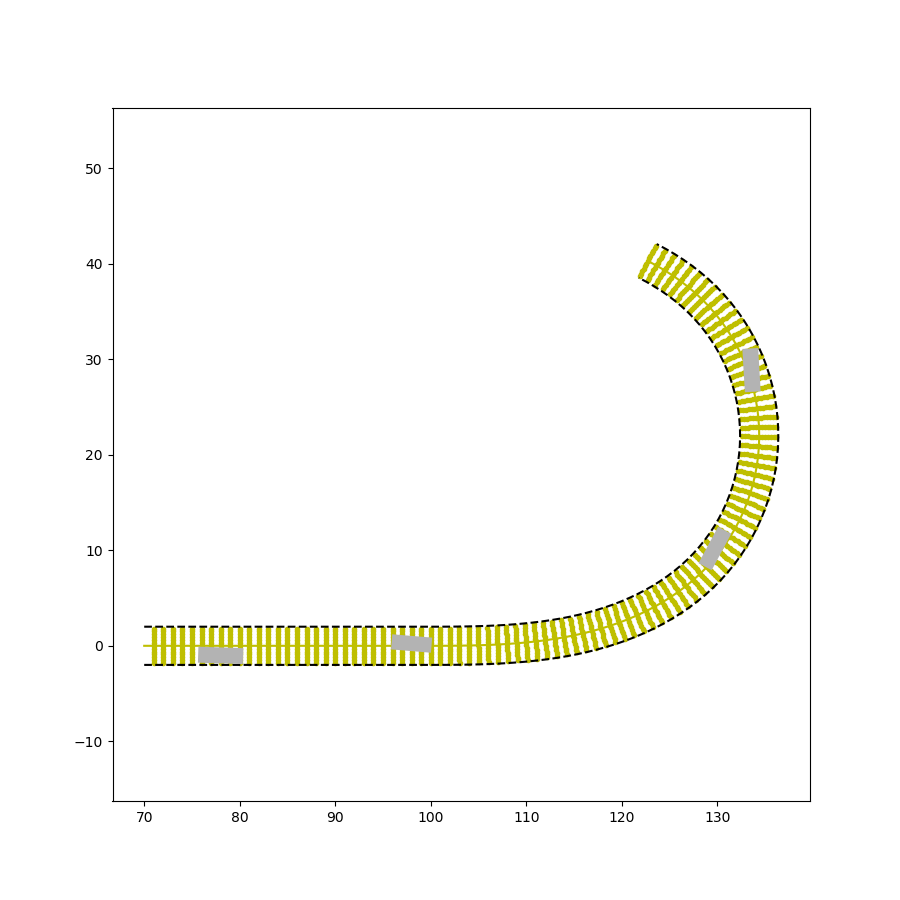

In [10]:
def sl_to_cart(l, cart_base, theta):
    x = cart_base[0] + np.cos(theta + np.pi / 2) * l
    y = cart_base[1] + np.sin(theta + np.pi / 2) * l
    return x,y
    


region_s = [70, 170]
lattice_lateral_step = 0.3
lattice_lateral_N = int(lane_width / lattice_lateral_step)
lattice_path = []

class static_obstacle:
    def __init__(self, sl = None, size = [0,0], size_noise = [0,0], angle = 0, safeSize = 0.5, xy = None):
        self.sl = sl
        self.length = size[0] + np.random.random()*size_noise[0]
        self.width = size[1] + np.random.random()*size_noise[1]
        self.safeSize = safeSize
        self.angle = angle
        self.xy = []
        self.pts = None
        self.safePts = None
        
    def enable_cart(self, xy_base, theta_base):
        x,y = sl_to_cart(self.sl[1], xy_base, theta_base)
        self.xy = []
        self.xy.append(x)
        self.xy.append(y)
        
    def enable_pts(self):
        self.pts = box_plot_pts(self.xy, [self.length, self.width], self.angle)
        self.safePts = box_plot_pts(self.xy, [self.length + self.safeSize, self.width+self.safeSize], self.angle)
        
static_obstacle_set = []        
static_obstacle_num = 4
static_obstacle_size = [4,1.5]
static_obstacle_size_noise = [1, 0.25]
static_obstacle_safe_size = 1
for i in range(static_obstacle_num):
    s = region_s[0] + (region_s[1] - region_s[0]) / 8 * (2 * i + np.random.random()) + 3
    s = int(s)
    l = - lane_width / 2 + np.random.random() * lane_width
    l = l * 0.6
    sob = static_obstacle([s,l], static_obstacle_size, static_obstacle_size_noise, mid_lane.theta_set[s] + np.pi / 6 * (np.random.random() - 0.5), 
                          safeSize=static_obstacle_safe_size)
    sob.enable_cart([mid_lane.x_set[s], mid_lane.y_set[s]], mid_lane.theta_set[s])
    sob.enable_pts()
    static_obstacle_set.append(sob)
    
    
fig, ax = plt.subplots(1)

for ob in static_obstacle_set:
#     plt.plot(ob.pts[0,:], ob.pts[1,:], linewidth = 2, color = 'k', zorder = 0)
    a = PolyCollection([ob.pts.transpose()], facecolors = np.asarray([1,1,1])*0.7, zorder = 200)
    ax.add_collection(a)
        
        
        
for i in range(region_s[0]+1, region_s[1]):
    lattice_line = [[],[],[],[]]
    for j in range(lattice_lateral_N):
        l = lattice_lateral_step * (j - int(lattice_lateral_N / 2))
        x,y = sl_to_cart(l, [mid_lane.x_set[i],mid_lane.y_set[i]], mid_lane.theta_set[i])
        lattice_line[0].append(x)
        lattice_line[1].append(y)
        lattice_line[2].append(mid_lane.s_set[i])
        lattice_line[3].append(l)
    plt.plot(lattice_line[0], lattice_line[1], 'y.')
    lattice_path.append(lattice_line)
    
    





plt.plot(mid_lane.x_set[region_s[0]: region_s[1]], mid_lane.y_set[region_s[0]: region_s[1]],'y-')
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()

In [12]:
start_point_sl = [region_s[0], 0]
start_point_index = int(region_s[0])
start_point_xy = sl_to_cart(start_point_sl[1], [mid_lane.x_set[start_point_index], mid_lane.y_set[start_point_index]], 
                            mid_lane.theta_set[start_point_index])

<IPython.core.display.Javascript object>


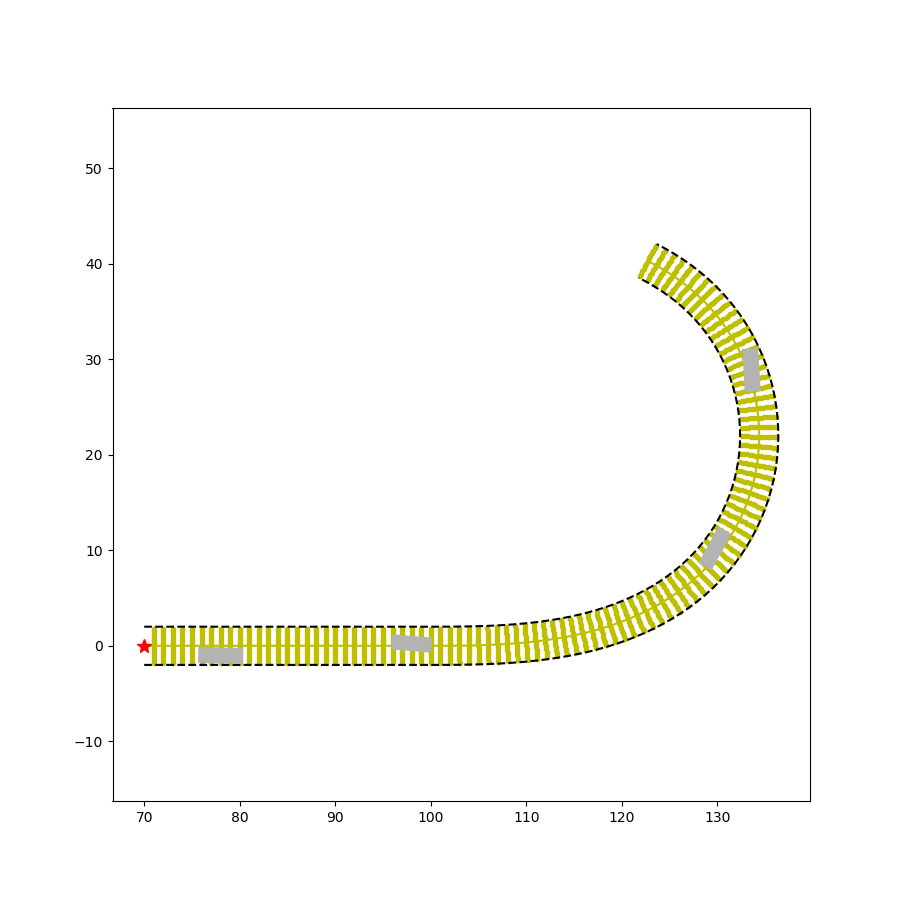

In [13]:
fig, ax = plt.subplots(1)

plt.plot(start_point_xy[0], start_point_xy[1],"r*", markersize = 10, zorder = 100000)

for ob in static_obstacle_set:
#     plt.plot(ob.pts[0,:], ob.pts[1,:], linewidth = 2, color = 'k', zorder = 0)
    a = PolyCollection([ob.pts.transpose()], facecolors = np.asarray([1,1,1])*0.7, zorder = 200)
    ax.add_collection(a)
           
for lattice_line in lattice_path:
    plt.plot(lattice_line[0], lattice_line[1], 'y.')
    

plt.plot(mid_lane.x_set[region_s[0]: region_s[1]], mid_lane.y_set[region_s[0]: region_s[1]],'y-')
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()

In [15]:
# polygon is area. if edge, it will be pointed out.
def Cross3Point(p0, p1, p2):
    dx01 = p1[0] - p0[0]
    dy01 = p1[1] - p0[1]
    dx12 = p2[0] - p1[0]
    dy12 = p2[1] - p1[1]
    return dx01 * dy12 - dy01 * dx12

def IfLineCross(line1, line2):
    p1, p2 = line1
    q1, q2 = line2
    if Cross3Point(q1, p1, p2) * Cross3Point(q2, p1, p2) <= 0 and Cross3Point(p1, q1,q2) * Cross3Point(p2, q1,q2) <= 0:
        return True
    return False

def IfPointInPolygon(p, polygon): # convex; if concave, should use number of intersection points
    polygonArray = np.asarray(polygon)
    minX = np.min(polygonArray[:,0])
    maxX = np.max(polygonArray[:,0])
    minY = np.min(polygonArray[:,1])
    maxY = np.max(polygonArray[:,1])
    if p[0] > maxX or p[0] < minX or p[1] > maxY or p[1] < minY:
        return False
    sign = []
    for i in range(len(polygon) - 1):
        tempSign = (Cross3Point(p, polygon[i], polygon[i+1]) >= 0)
        if sign != []:
            if tempSign != sign[-1]:
                return False
        sign.append(tempSign)
    return True

def IfLineCrossPolygon(line, polygon):
    for i in range(len(polygon)-1):
        if IfLineCross(line, polygon[i:i+2]):
            return True
    if IfPointInPolygon(line[0], polygon):
        return True
    return False
        
# verify IfPointInPolygon
# polygon = [[0,0],[0,1],[1,1],[1,0],[0,0]]
# polygonArray = np.asarray(polygon)
# p = [0.5,1]
# plt.plot(p[0],p[1],"*")
# plt.plot(polygonArray[:,0],polygonArray[:,1])
# IfPointInPolygon(p,polygon)      

# verifiy IfLineCross
# line1 = [[0,0],[1,1]]
# line2 = [[0,0],[0.5,0]]
# line1Array = np.asarray(line1)
# line2Array = np.asarray(line2)
# plt.plot(line1Array[:,0], line1Array[:,1])
# plt.plot(line2Array[:,0], line2Array[:,1])
# IfLineCross(line1, line2





<IPython.core.display.Javascript object>


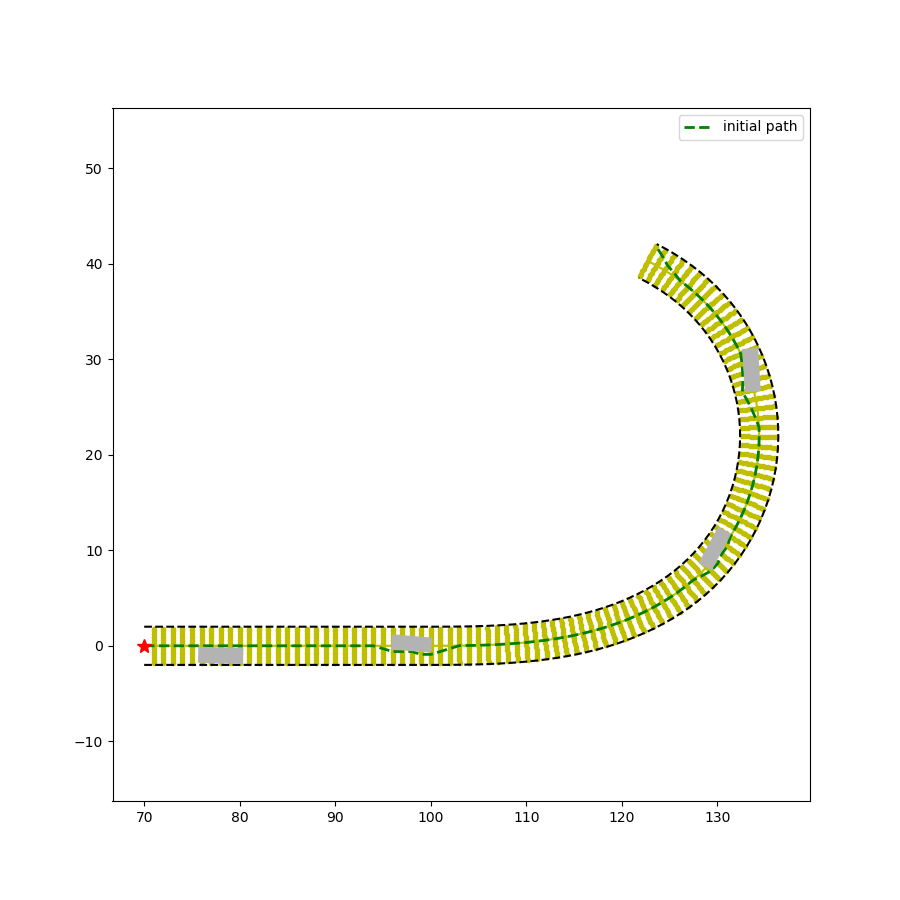

In [16]:
def EulDis(p0,p1):
    return ((p0[0]-p1[0])**2 + (p1[1]- p0[1])**2)**0.5

stack = [[list(start_point_xy), 0, [0]]]
weight = [1,0.1,1]


fig, ax = plt.subplots(1)

for i in range(len(lattice_path)):
    newStack = []
    for j in range(len(lattice_path[i][0])):
        tempStack = []
        tempP = [lattice_path[i][0][j], lattice_path[i][1][j]]
        tempStack.append(tempP)
        tempCost = []
        for k in range(len(stack)):
            d = EulDis(stack[k][0], tempP)
            deviation = np.abs(lattice_path[i][3][j])
            
            
            collisionCost = 0
            line = [stack[k][0], tempP]
            for ob in static_obstacle_set:
                polygon = [[ob.pts[0,i], ob.pts[1,i]] for i in range(ob.pts.shape[1])]
                if IfLineCrossPolygon(line, polygon):
                    collisionCost = 1000
#                     plt.plot([line[0][0], line[1][0]],[line[0][1],line[1][1]], linewidth = 1, color = 'b')
                    break
                    
            cost_set = [d, deviation, collisionCost]

            cost = np.sum([cost_set[i]*weight[i] for i in range(len(cost_set))])
            tempCost.append(cost + stack[k][1])
        minCost = np.min(tempCost)
        minIndex = tempCost.index(minCost)
        tempStack.append(minCost)
        tempStack.append(stack[minIndex][2] + [j])
        newStack.append(tempStack)
        
    stack = newStack
        
        
ReferencePath = [[start_point_xy[0]],[start_point_xy[1]]]
for i in range(1,len(stack[0][2])):
    ReferencePath[0].append(lattice_path[i-1][0][stack[0][2][i]])
    ReferencePath[1].append(lattice_path[i-1][1][stack[0][2][i]])
    
plt.plot(ReferencePath[0], ReferencePath[1], 'g--', linewidth = 2, zorder = 100,label = 'initial path')
plt.legend()

plt.plot(start_point_xy[0], start_point_xy[1],"r*", markersize = 10, zorder = 100000)

for ob in static_obstacle_set:
#     plt.plot(ob.pts[0,:], ob.pts[1,:], linewidth = 2, color = 'k', zorder = 0)
    a = PolyCollection([ob.pts.transpose()], facecolors = np.asarray([1,1,1])*0.7, zorder = 200)
    ax.add_collection(a)
           
for lattice_line in lattice_path:
    plt.plot(lattice_line[0], lattice_line[1], 'y.')
    

plt.plot(mid_lane.x_set[region_s[0]: region_s[1]], mid_lane.y_set[region_s[0]: region_s[1]],'y-')
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()  

        

#### Smooth the road points
The problem is that the initial path is not smooth. The idea from the reference paper[1]. Assume the initial path point as $p^{ref}_i=(x_i^{ref},y_i^{ref})$, $i=0,1,2,...,n-1$, and smoothed path point as $p_i$. The problem can be formulated as 
$$
\begin{align}
\min_{p_i} & w_1\sum_{i=0}^{n-1}||p_i-p_i^{ref}||_2^2+w_2\sum_{i=1}^{n-2}||2p_i-(p_{i-1}+p_{i+1})||_2^2\\
s.t.&||x_i-x_i^{ref}||_1\le a_i, \forall i = 0,1,2,...,n-1\\
&||y_i-y_i^{ref}||_1\le b_i, \forall i = 0,1,2,...,n-1
\end{align}
$$
where $a_i$ and $b_i$ are the limitations of deviations from reference points. The first term is to penalize the deviations. The second term is to penalize the small curvature. The problem is QP and easy to solve. However, the solution can not guarantee the max curvature of the path is smaller than physical limitation in autopilot. When regarding the curvature limitation as strict constraints, the problem will become nonlinear optimization problem (see some methods to calculate curvature below). It is a trade-off.

#### Curvature
- *1)* From velocity and chord length. Assume $v_1$ and $v_2$ are the velocities of two adjacent path point, $l$ is the length between two adjacent path point. The curvature $\kappa$ can be calculated as 
$$
\kappa = \frac{|\frac{v_1}{|v_1|}-\frac{v_2}{|v_2|}|}{l}
$$
- *2)* From three points. Assume the lengths between any two points are $l_1$, $l_2$ and $l_3$, $p = (l_1+l_2+l_3)/2$. 
$$
\kappa = \frac{4\sqrt{p(p-l_1)(p-l_2)(p-l3)}}{l_1l_2l_3}
$$

#### Reference
[1] Zhang, Yajia, et al. "Optimal Vehicle Path Planning Using Quadratic Optimization for Baidu Apollo Open Platform." 2020 IEEE Intelligent Vehicles Symposium (IV). IEEE, 2020.

In [17]:
weightSmoothReferencePath = [1,100, 100]
w1, w2, w3 = weightSmoothReferencePath
numOfPts = len(ReferencePath[0])
A = np.zeros(shape = (numOfPts, numOfPts))
bx = np.zeros(shape = (numOfPts, 1))
by = np.zeros(shape = (numOfPts, 1))
boundaryBox = [1,1]
uX = np.zeros(shape = (numOfPts, 1))
uY = np.zeros(shape = (numOfPts, 1))
lX = np.zeros(shape = (numOfPts, 1))
lY = np.zeros(shape = (numOfPts, 1))
x0 = np.zeros(shape = (numOfPts,1))
y0 = np.zeros(shape = (numOfPts,1))
for i in range(numOfPts):
    if i != 0 and i != numOfPts-1:
        A[i,i] += w1
        
        A[i,i] += w2
        A[i-1,i-1] += w2/4
        A[i+1,i+1] += w2/4
        
        A[i-1, i+1] += w2/4
        A[i+1, i-1] += w2/4
        A[i, i-1] += -w2 /2
        A[i-1,i] += -w2/2
        A[i,i+1] += -w2/2
        A[i+1,i] += -w2/2
    else:
        A[i,i] += w3
for i in range(numOfPts):
    if i != 0 and i != numOfPts-1:
        bx[i] = -2*w1*ReferencePath[0][i]
        by[i] = -2*w1*ReferencePath[1][i]
    else:
        bx[i] = -2*w3*ReferencePath[0][i]
        by[i] = -2*w3*ReferencePath[1][i]
    lX[i] = ReferencePath[0][i]-boundaryBox[0]
    uX[i] = ReferencePath[0][i]+boundaryBox[0]
    lY[i] = ReferencePath[1][i]-boundaryBox[1]
    uY[i] = ReferencePath[1][i]+boundaryBox[1]
    x0[i] = ReferencePath[0][i]
    y0[i] = ReferencePath[1][i]
    
smoothX = -0.5 * np.linalg.inv(A.transpose().dot(A)).dot(A.transpose().dot(bx))
smoothY = -0.5 * np.linalg.inv(A.transpose().dot(A)).dot(A.transpose().dot(by))

# constrained QP

# squareSumX = 0
# squareSumY = 0
# for i in range(numOfPts):
#     if i != 0 or i != numOfPts - 1:
#         squareSumX += ReferencePath[0][i]**2 * w1
#         squareSumY += ReferencePath[1][i]**2 * w1
#     else:
#         squareSumX += ReferencePath[0][i]**2 * w3
#         squareSumY += ReferencePath[1][i]**2 * w3

# def opt_fun_x(x):
#     tx = x.reshape(numOfPts, 1)
#     return (tx.transpose().dot(A).dot(tx) + bx.transpose().dot(tx))[0][0] + squareSumX

# def opt_jac_x(x):
#     tx = x.reshape(numOfPts, 1)
#     return (2*A.dot(tx) + bx).reshape(numOfPts)

# resX = optimize.minimize(opt_fun_x, x0.reshape(numOfPts),method = "SLSQP", jac = opt_jac_x, 
#                               bounds=scipy.optimize.Bounds(lb = lX.reshape(numOfPts), ub = uX.reshape(numOfPts)), options = {'disp': True})

# def opt_fun_y(x):
#     tx = x.reshape(numOfPts, 1)
#     return (tx.transpose().dot(A).dot(tx) + by.transpose().dot(tx))[0][0] + squareSumY

# def opt_jac_y(x):
#     tx = x.reshape(numOfPts, 1)
#     return (2*A.dot(tx) + by).reshape(numOfPts)

# resY = optimize.minimize(opt_fun_y, y0.reshape(numOfPts),method = "SLSQP", jac = opt_jac_y, 
#                               bounds=scipy.optimize.Bounds(lb = lY.reshape(numOfPts), ub = uY.reshape(numOfPts)), options = {'disp': True})
# print(opt_fun_x(x0), resX.fun, opt_fun_y(y0),resY.fun)
# sm1 = [resX.x, resY.x]

<IPython.core.display.Javascript object>


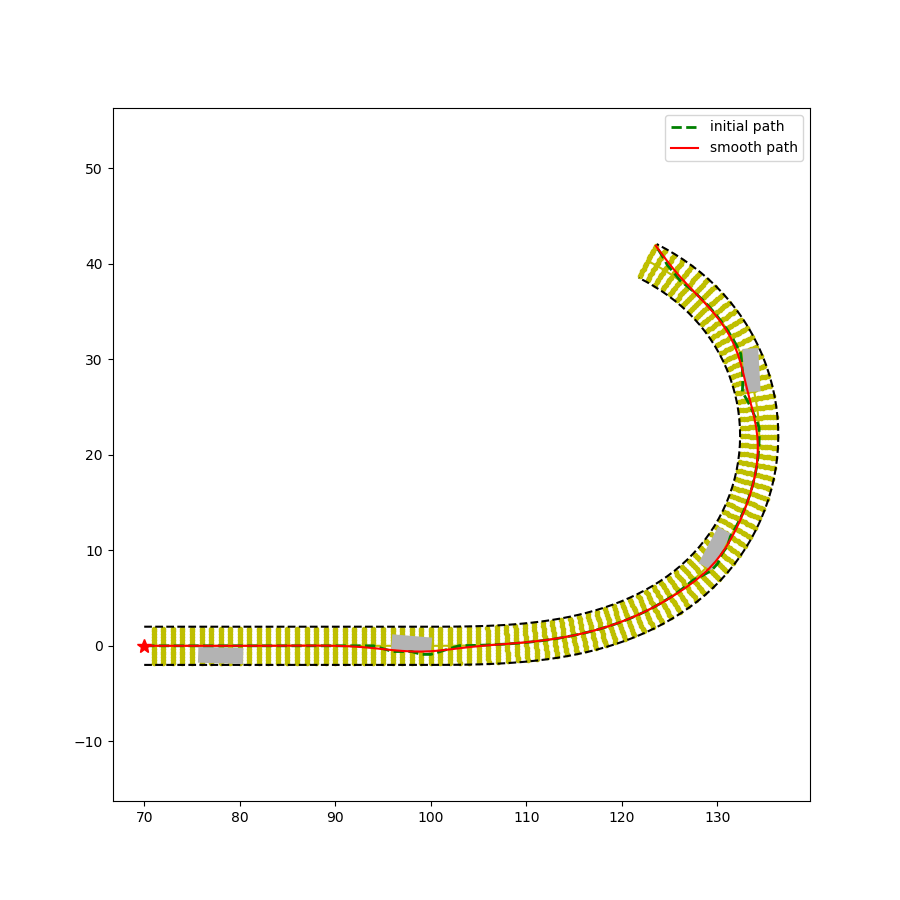

may collide.


In [18]:
fig, ax = plt.subplots(1)
    
plt.plot(ReferencePath[0], ReferencePath[1], 'g--', linewidth = 2, zorder = 1000,label = 'initial path')
plt.plot(smoothX, smoothY,'r-',label = 'smooth path', zorder = 10000)
plt.legend()
# plt.plot(sm1[0],sm1[1],'y-')

plt.plot(start_point_xy[0], start_point_xy[1],"r*", markersize = 10, zorder = 100000)

for ob in static_obstacle_set:
#     plt.plot(ob.pts[0,:], ob.pts[1,:], linewidth = 2, color = 'k', zorder = 0)
    a = PolyCollection([ob.pts.transpose()], facecolors = np.asarray([1,1,1])*0.7, zorder = 200)
    ax.add_collection(a)
           
for lattice_line in lattice_path:
    plt.plot(lattice_line[0], lattice_line[1], 'y.')
    

plt.plot(mid_lane.x_set[region_s[0]: region_s[1]], mid_lane.y_set[region_s[0]: region_s[1]],'y-')
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()  

print("may collide.")

### solution to collision when smoothing
enlarge the obstacles and than change unconstrained QP problem to constrained QP problem. Note that the initial path $p_i^{ref}$ is collision-free. We can increase the length and width of the box by $max\{a_i,b_i\}$.

In [19]:
def EulDis(p0,p1):
    return ((p0[0]-p1[0])**2 + (p1[1]- p0[1])**2)**0.5

stack = [[list(start_point_xy), 0, [0]]]
weight = [1,0.1,1]


# fig, ax = plt.subplots(1)

for i in range(len(lattice_path)):
    newStack = []
    for j in range(len(lattice_path[i][0])):
        tempStack = []
        tempP = [lattice_path[i][0][j], lattice_path[i][1][j]]
        tempStack.append(tempP)
        tempCost = []
        for k in range(len(stack)):
            d = EulDis(stack[k][0], tempP)
            deviation = np.abs(lattice_path[i][3][j])
            
            
            collisionCost = 0
            line = [stack[k][0], tempP]
            for ob in static_obstacle_set:
                polygon = [[ob.safePts[0,i], ob.safePts[1,i]] for i in range(ob.safePts.shape[1])]
                if IfLineCrossPolygon(line, polygon):
                    collisionCost = 1000
#                     plt.plot([line[0][0], line[1][0]],[line[0][1],line[1][1]], linewidth = 1, color = 'b')
                    break
                    
            cost_set = [d, deviation, collisionCost]

            cost = np.sum([cost_set[i]*weight[i] for i in range(len(cost_set))])
            tempCost.append(cost + stack[k][1])
        minCost = np.min(tempCost)
        minIndex = tempCost.index(minCost)
        tempStack.append(minCost)
        tempStack.append(stack[minIndex][2] + [j])
        newStack.append(tempStack)
        
    stack = newStack

<IPython.core.display.Javascript object>


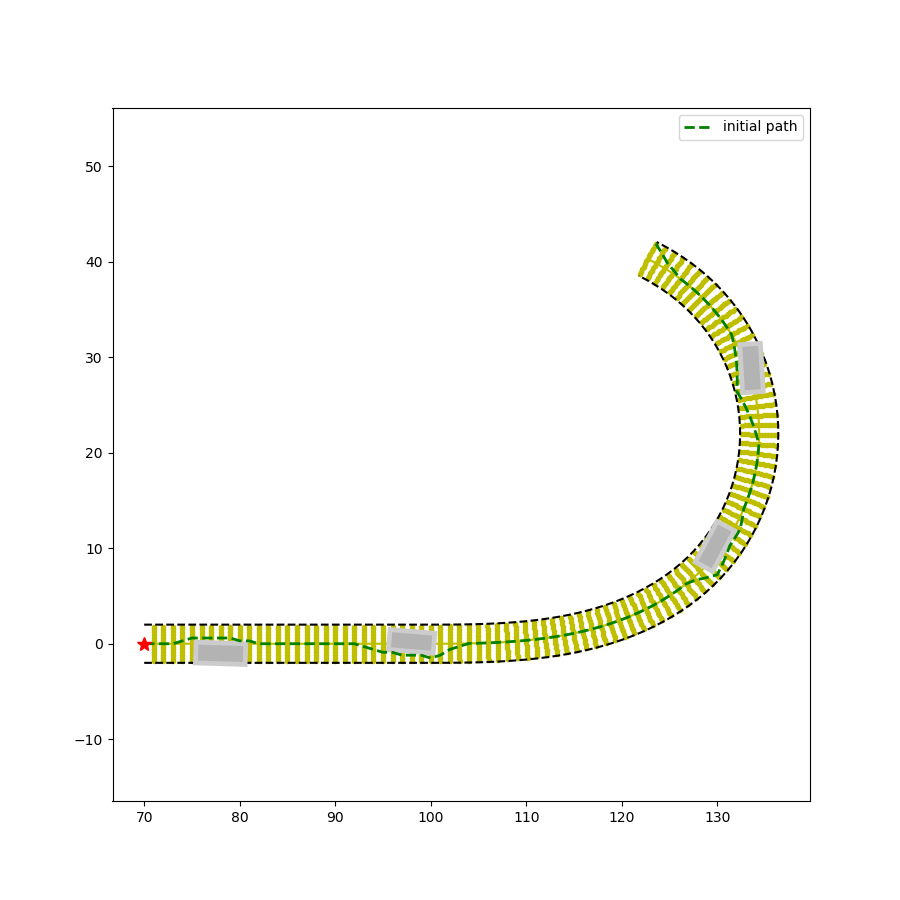

In [20]:
fig, ax = plt.subplots(1)
ReferencePath = [[start_point_xy[0]],[start_point_xy[1]]]
for i in range(1,len(stack[0][2])):
    ReferencePath[0].append(lattice_path[i-1][0][stack[0][2][i]])
    ReferencePath[1].append(lattice_path[i-1][1][stack[0][2][i]])
    
plt.plot(ReferencePath[0], ReferencePath[1], 'g--', linewidth = 2, zorder = 10000,label='initial path')


plt.plot(start_point_xy[0], start_point_xy[1],"r*", markersize = 10, zorder = 100000)

for ob in static_obstacle_set:
#     plt.plot(ob.safePts[0,:], ob.safePts[1,:], linewidth = 1, color = np.asarray([1,1,1])*0.3, zorder = 200)
    a = PolyCollection([ob.pts.transpose()], facecolors = np.asarray([1,1,1])*0.7, zorder = 200)
    b = PolyCollection([ob.safePts.transpose()], facecolors = np.asarray([255,255, 255])/255*0.8, zorder = 100)
    ax.add_collection(a)
    ax.add_collection(b)
           
for lattice_line in lattice_path:
    plt.plot(lattice_line[0], lattice_line[1], 'y.')
plt.legend()

plt.plot(mid_lane.x_set[region_s[0]: region_s[1]], mid_lane.y_set[region_s[0]: region_s[1]],'y-')
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()  

In [21]:
weightSmoothReferencePath = [1,100, 100]
w1, w2, w3 = weightSmoothReferencePath
numOfPts = len(ReferencePath[0])
A = np.zeros(shape = (numOfPts, numOfPts))
bx = np.zeros(shape = (numOfPts, 1))
by = np.zeros(shape = (numOfPts, 1))
boundaryBox = [static_obstacle_safe_size,static_obstacle_safe_size]
uX = np.zeros(shape = (numOfPts, 1))
uY = np.zeros(shape = (numOfPts, 1))
lX = np.zeros(shape = (numOfPts, 1))
lY = np.zeros(shape = (numOfPts, 1))
x0 = np.zeros(shape = (numOfPts,1))
y0 = np.zeros(shape = (numOfPts,1))
for i in range(numOfPts):
    if i != 0 and i != numOfPts-1:
        A[i,i] += w1
        
        A[i,i] += w2
        A[i-1,i-1] += w2/4
        A[i+1,i+1] += w2/4
        
        A[i-1, i+1] += w2/4
        A[i+1, i-1] += w2/4
        A[i, i-1] += -w2 /2
        A[i-1,i] += -w2/2
        A[i,i+1] += -w2/2
        A[i+1,i] += -w2/2
    else:
        A[i,i] += w3
for i in range(numOfPts):
    if i != 0 and i != numOfPts-1:
        bx[i] = -2*w1*ReferencePath[0][i]
        by[i] = -2*w1*ReferencePath[1][i]
    else:
        bx[i] = -2*w3*ReferencePath[0][i]
        by[i] = -2*w3*ReferencePath[1][i]
    lX[i] = ReferencePath[0][i]-boundaryBox[0]
    uX[i] = ReferencePath[0][i]+boundaryBox[0]
    lY[i] = ReferencePath[1][i]-boundaryBox[1]
    uY[i] = ReferencePath[1][i]+boundaryBox[1]
    x0[i] = ReferencePath[0][i]
    y0[i] = ReferencePath[1][i]
    
smoothX = -0.5 * np.linalg.inv(A.transpose().dot(A)).dot(A.transpose().dot(bx))
smoothY = -0.5 * np.linalg.inv(A.transpose().dot(A)).dot(A.transpose().dot(by))

# constrained QP

squareSumX = 0
squareSumY = 0
for i in range(numOfPts):
    if i != 0 or i != numOfPts - 1:
        squareSumX += ReferencePath[0][i]**2 * w1
        squareSumY += ReferencePath[1][i]**2 * w1
    else:
        squareSumX += ReferencePath[0][i]**2 * w3
        squareSumY += ReferencePath[1][i]**2 * w3

def opt_fun_x(x):
    tx = x.reshape(numOfPts, 1)
    return (tx.transpose().dot(A).dot(tx) + bx.transpose().dot(tx))[0][0] + squareSumX

def opt_jac_x(x):
    tx = x.reshape(numOfPts, 1)
    return (2*A.dot(tx) + bx).reshape(numOfPts)

resX = optimize.minimize(opt_fun_x, x0.reshape(numOfPts),method = "SLSQP", jac = opt_jac_x, 
                              bounds=scipy.optimize.Bounds(lb = lX.reshape(numOfPts), ub = uX.reshape(numOfPts)), options = {'disp': True})

def opt_fun_y(x):
    tx = x.reshape(numOfPts, 1)
    return (tx.transpose().dot(A).dot(tx) + by.transpose().dot(tx))[0][0] + squareSumY

def opt_jac_y(x):
    tx = x.reshape(numOfPts, 1)
    return (2*A.dot(tx) + by).reshape(numOfPts)

resY = optimize.minimize(opt_fun_y, y0.reshape(numOfPts),method = "SLSQP", jac = opt_jac_y, 
                              bounds=scipy.optimize.Bounds(lb = lY.reshape(numOfPts), ub = uY.reshape(numOfPts)), options = {'disp': True})
print(opt_fun_x(x0), resX.fun, opt_fun_y(y0),resY.fun)
sm1 = [resX.x, resY.x]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1996869.8227659385
            Iterations: 91
            Function evaluations: 272
            Gradient evaluations: 91
Optimization terminated successfully    (Exit mode 0)
            Current function value: -173689.28292959876
            Iterations: 93
            Function evaluations: 273
            Gradient evaluations: 93
-1996841.6345014796 -1996869.8227659385 -173633.50009512686 -173689.28292959876


<IPython.core.display.Javascript object>


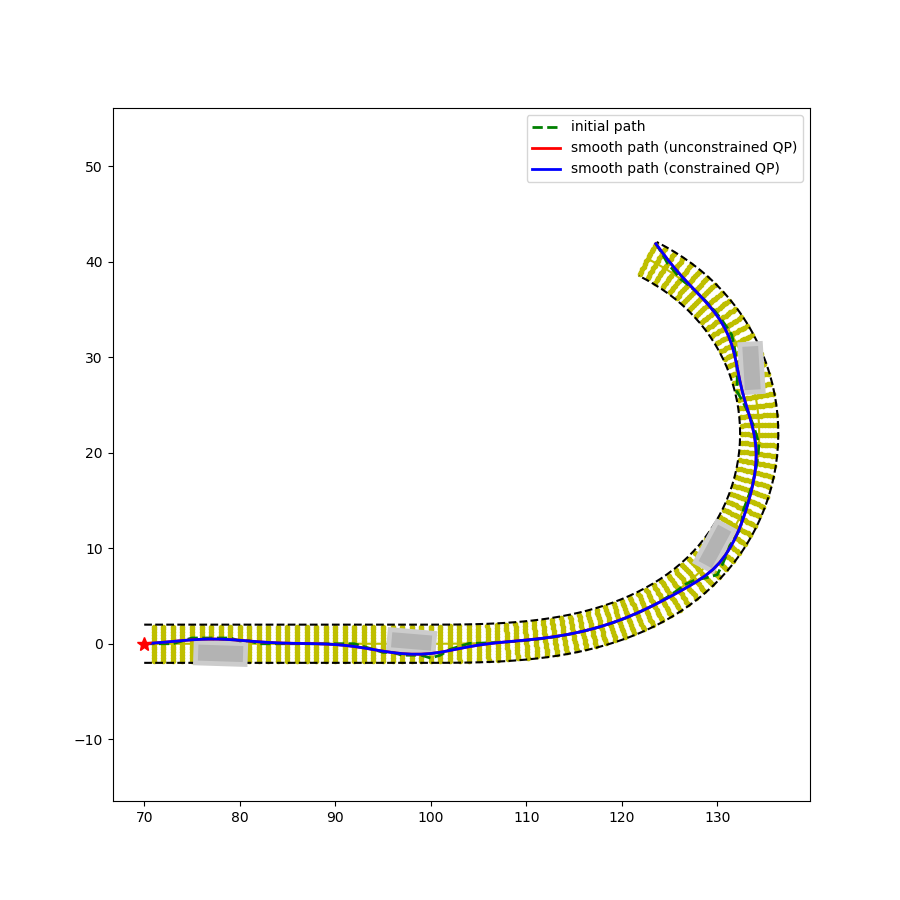

In [22]:
fig, ax = plt.subplots(1)
ReferencePath = [[start_point_xy[0]],[start_point_xy[1]]]
for i in range(1,len(stack[0][2])):
    ReferencePath[0].append(lattice_path[i-1][0][stack[0][2][i]])
    ReferencePath[1].append(lattice_path[i-1][1][stack[0][2][i]])
    
plt.plot(ReferencePath[0], ReferencePath[1], 'g--', linewidth = 2, zorder = 1000, label = 'initial path')
plt.plot(smoothX,smoothY,  'r-', linewidth = 2, zorder = 1000, label = 'smooth path (unconstrained QP)')
plt.plot(sm1[0],sm1[1], 'b-', linewidth = 2, zorder = 1000, label = 'smooth path (constrained QP)')
plt.legend()

plt.plot(start_point_xy[0], start_point_xy[1],"r*", markersize = 10, zorder = 100000)

for ob in static_obstacle_set:
#     plt.plot(ob.safePts[0,:], ob.safePts[1,:], linewidth = 1, color = np.asarray([1,1,1])*0.3, zorder = 200)
    a = PolyCollection([ob.pts.transpose()], facecolors = np.asarray([1,1,1])*0.7, zorder = 200)
    b = PolyCollection([ob.safePts.transpose()], facecolors = np.asarray([255,255, 255])/255*0.8, zorder = 100)
    ax.add_collection(a)
    ax.add_collection(b)
           
for lattice_line in lattice_path:
    plt.plot(lattice_line[0], lattice_line[1], 'y.')
    

plt.plot(mid_lane.x_set[region_s[0]: region_s[1]], mid_lane.y_set[region_s[0]: region_s[1]],'y-')
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()  

Collision-free now.

### avoid moving objects

In [24]:
class moving_object:
    def __init__(self, sl, size, size_noise, angle, v = 0, trajectory = [], safeSize = 0.5):
        self.sl = sl
        self.length = size[0] + np.random.random()*size_noise[0]
        self.width = size[1] + np.random.random()*size_noise[1]
        self.safeSize = safeSize
        self.angle = angle
        self.xy = []
        self.pts = None
        self.safePts = None
        self.trajectory = trajectory
        self.trajectoryPts = []
        self.trajectorySafePts = []
        self.v = v
    
    def set_trajectory(self, trajectory):
        self.trajectory = trajectory
        self.angle = trajectory.theta_set[0]
    
    def enable_cart(self, xy_base, theta_base):
        x,y = sl_to_cart(self.sl[1], xy_base, theta_base)
        self.xy = []
        self.xy.append(x)
        self.xy.append(y)
        
    def enable_pts(self):
        self.pts = box_plot_pts(self.xy, [self.length, self.width], self.angle)
        self.safePts = box_plot_pts(self.xy, [self.length + self.safeSize, self.width+self.safeSize], self.angle)
        
    def enable_trajectory_pts(self):
        for i in range(len(self.trajectory.x_set)):
            self.trajectoryPts.append(box_plot_pts([self.trajectory.x_set[i], self.trajectory.y_set[i]], [self.length, self.width], self.trajectory.theta_set[i]))
            self.trajectorySafePts.append(box_plot_pts([self.trajectory.x_set[i], self.trajectory.y_set[i]], [self.length + self.safeSize, self.width + self.safeSize], self.trajectory.theta_set[i]))

        

In [25]:
moving_object_set = []        
moving_object_num = 4
moving_object_size = [4,1.5]
moving_object_size_noise = [1, 0.25]
moving_object_safe_size = 1
along_lane_index = [np.random.randint(moving_object_num), np.random.randint(moving_object_num)]
standard_v_set = [5,10,15,20]
np.random.shuffle(standard_v_set)
for i in range(moving_object_num):
    s = region_s[0] + (region_s[1] - region_s[0]) / 8 * (2 * i + np.random.random()) + 3
    s = int(s)
    l = - lane_width / 2 + np.random.random() * lane_width
    l = l * 0.6
    v = standard_v_set[i]+(np.random.random()-0.5)*5
    mob = moving_object([s,l], moving_object_size, moving_object_size_noise, mid_lane.theta_set[s] + np.pi / 6 * (np.random.random() - 0.5), 
                          v, safeSize=moving_object_safe_size)
    mob.enable_cart([mid_lane.x_set[s], mid_lane.y_set[s]], mid_lane.theta_set[s])
    x, y = mob.xy
    
    theta = np.pi*(np.random.random()-0.5) * 0 + mid_lane.theta_set[s]
    if np.random.random() < 0.3:
        theta = theta + np.pi
    dtheta = np.pi/18
    x_set = []
    y_set = []
    theta_set = []
    s_set = []
    t_set = []
    tempTrajectory = trajectory()
    T = 4
    dt = 0.05
    sumS = 0
    ds = v * dt
    t = 0
    for j in range(int(T/dt)):
        x_set.append(x)
        y_set.append(y)
        s_set.append(sumS)
        t_set.append(t)
        theta_set.append(theta)
        x += ds * np.cos(theta)
        y += ds * np.sin(theta)
        sumS += ds
        if sumS > 50:
            break
        t += dt
        if i not in along_lane_index:
            theta += dtheta*(np.random.random()-0.5)
        else:
            theta = mid_lane.theta_set[int(s + sumS)]
    tempTrajectory.set_value(x_set = x_set, y_set = y_set, s_set = s_set, theta_set = theta_set, t_set = t_set)
    mob.set_trajectory(tempTrajectory)
    mob.enable_pts()
    mob.enable_trajectory_pts()
    moving_object_set.append(mob)

<IPython.core.display.Javascript object>


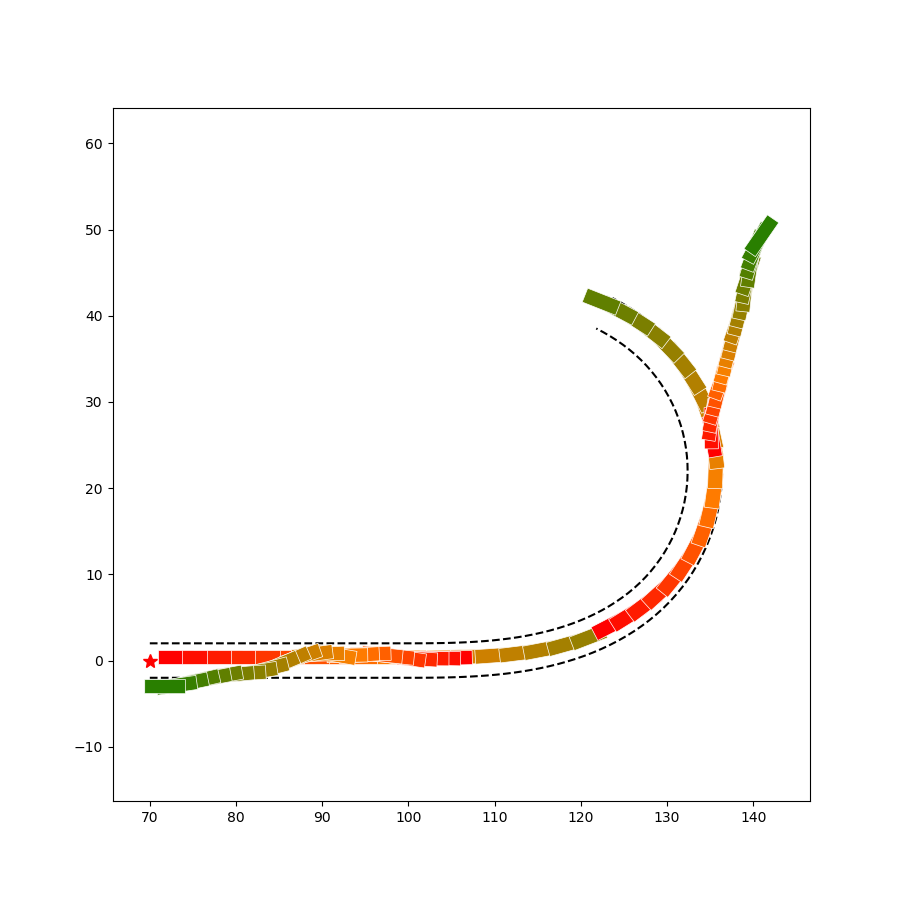

In [26]:
fig, ax = plt.subplots(1)

egoSpeed = 20
estimatedT = (region_s[1]-region_s[0])/egoSpeed
tRange = estimatedT + 2

plt.plot(start_point_xy[0], start_point_xy[1],"r*", markersize = 10, zorder = 100000)
colors = [np.asarray([1,0,0]), np.asarray([1,0.5,0]), np.asarray([0.5,0.5,0]), np.asarray([0,0.5,0]), np.asarray([0,0.5,0.5]), np.asarray([0,0,1])]
valueColors = [i / (len(colors)-1) for i in range(len(colors))]


for mob in moving_object_set:
#     plt.plot(mob.pts[0,:], mob.pts[1,:], linewidth = 1, color = np.asarray([1,1,1])*0.3, zorder = 200)
    step = 3
    N = int(len(mob.trajectoryPts)/step)
    for i in range(N):
        index = step * i
        co = mob.trajectory.t_set[index]/tRange
        colorTemp = np.asarray([1,0,0])
        for j in range(len(colors)-1):
            if co >=valueColors[j] and co < valueColors[j+1]:
                colorTemp = (colors[j+1] * (co - valueColors[j]) + colors[j] * (valueColors[j+1] - co))*(len(colors)-1)
        a = PolyCollection([mob.trajectoryPts[index].transpose()], facecolors = colorTemp,linewidths=(0.5,),
                           edgecolors = 'w', zorder = 200)
        ax.add_collection(a)

        
        
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()  

The picture above shows a simulation environment generated randomly. The red star is the current position of the ego vehicle and the boxes are the moving obstacles. The colors are from red to green, which represents the time from 0s to 10s.

### sampling-based method

After considering many methods to avoid moving objects, I choose to start with RRT. It takes a long time to consider how to improve the lattice planner so that it can apply to moving objects avoidance. I know that we can add a penalty function to avoid moving objects but it is not solid enough. The conclusion is that I fail. It is hard to find the optimal solution. On the other hand, decoupling the path planning and velocity planning is not my choice because it is very common in autopilot. I want something challengable.

In [27]:
class node:
    def __init__(self, p, parent = None, cost = 0):
        self.p = p
        self.parent = parent
        self.cost = cost


def SamplingInBound(bound):
    return np.asarray([np.random.random()*(oneRange[1]-oneRange[0])+oneRange[0] for oneRange in bound])

def LengthCut(p0, p1, l, pf = None, criDim = None, criL = None):
    if pf is not None:
        if criDim is None:
            if np.linalg.norm(p0 - pf) < l:
                return pf
        else:
            if np.linalg.norm(p0[criDim] - pf[criDim]) < criL:
                tempP = copy.deepcopy(pf)
                tempP[0] = (criL**2 - np.linalg.norm(p0[criDim] - pf[criDim])**2)**0.5 + p0[0]
                print(tempP)
                return tempP
    v = p1 - p0
    lv = np.linalg.norm(p1 - p0)
    if lv < 0.01:
        return p0
    else:
        if lv > l:
            return v / lv * l + p0
        else:
            return p1
    
def IfInBound(p0, bound):
    for i in range(p0.shape[0]):
        if p0[i] > bound[i][1] or p0[i] < bound[i][0]:
            return False
    return True

def IfEnd(p, pf, epsilon):
    if np.linalg.norm(p - pf) < epsilon:
        return True
    return False

def PathPIndex(parentIndex):
    pathPIndex = [len(parentIndex) - 1]
    while True:
        tempIndex = parentIndex[pathPIndex[-1]]
        if tempIndex is not None:
            pathPIndex.append(tempIndex)
        else:
            break
    return pathPIndex

def BoxPtsFromBound(bound):
    return np.asarray([[bound[0][0], bound[0][1], bound[0][1], bound[0][0], bound[0][0]], 
            [bound[1][0], bound[1][0], bound[1][1], bound[1][1], bound[1][0]]])

def PathPoint(pSet, pathPIndex):
    return [pSet[i] for i in pathPIndex]

def PlotPoint(p, cm):
    plt.plot(p[0], p[1], cm)

def Plot2Point(p0, p1, cm):
    plt.plot([p0[0],p1[0]], [p0[1],p1[1]], cm)

def GenerateRandom(low, up):
    return np.random.random()*(up - low) + low

In [28]:
def PlotPoint3D(p, ax, color = 'r'):
    ax.scatter(p[0], p[1], p[2],color = color)
    
def PlotLine3D(line, ax, color = 'g', linewidths = 1):
    ax.add_collection3d(Line3DCollection(line, colors = color, linewidths = linewidths))
    
def IfCollision3D(line, verts):
    p0,p1 = line
    numOfSections = 10
    for i in range(numOfSections-1):
        tempXY = p0[1:] + (p1[1:] - p0[1:]) * i/numOfSections
        tempT = p0[0] + (p1[0] - p0[0]) * i/numOfSections
        polygon = []
        for j in range(int(len(verts)/4)-1):
            index = 4*j
            if verts[index][0]<= tempT and verts[index + 4][0]>= tempT:
                co = (tempT - verts[index][0]) / (verts[index+4][0] - verts[index][0])
                for k in range(4):
                    polygon.append([verts[index + k][m]+co*(verts[index+k+4][m]-verts[index+k][m]) for m in range(1,3)])
                break
        if polygon != []:
            if IfPointInPolygon(tempXY, polygon):
                return True
    return False

def SamplingInPolygon(polygon):
    dimension = len(polygon[0])
    polygonArray = np.asarray(polygon)
    boundPolygon = [[np.min(polygonArray[:,i]), np.max(polygonArray[:,i])]for i in range(dimension)]
    for i in range(1000):
        tempP = SamplingInBound(boundPolygon)
        if IfPointInPolygon(tempP, polygon):
            return tempP
    return None


import math
def CalAngle(point, node1, node2):
    edge1 = np.array([node1[0]-point[0], node1[1]-point[1]])
    edge2 = np.array([node2[0]-point[0], node2[1]-point[1]])
    norm = np.linalg.norm(edge1) * np.linalg.norm(edge2)
    if norm == 0:
        return 0
    rho = np.cross(edge1, edge2) / norm
    signal = 1 if rho <= 0 else -1
    cosangle = edge1.dot(edge2)/norm
    return np.arccos(cosangle) * signal

def VerifyPointInPolygon(polygon, point):
    anglesum = 0.0
    if len(polygon) < 3 or len(point) < 2:
        print('not valid')
        return False
    for i in range(-1, len(polygon)-1):
        anglesum += CalAngle(point, polygon[i], polygon[i+1])
    return abs(anglesum - 2 * math.pi) < 0.1**6

def SamplingInAny2DPolygon(polygon):
    dimension = 2
    polygonArray = np.asarray(polygon)
    boundPolygon = [[np.min(polygonArray[:,i]), np.max(polygonArray[:,i])]for i in range(dimension)]
    for i in range(1000):
        tempP = SamplingInBound(boundPolygon)
        if VerifyPointInPolygon(polygon, tempP):
            return tempP
    return None

In [29]:
import time
class Timer:
    def __init__(self):
        self.timeNow = time.time()
        
    def reset(self):
        self.timeNow = time.time()
        
    def TimeCostAndRenew(self):
        tempTimeNow = time.time()
        print("cost time:", tempTimeNow - self.timeNow)
        self.timeNow = tempTimeNow
        
    def TimeCost(self):
        tempTimeNow = time.time()
        print("cost time:", tempTimeNow - self.timeNow)

<IPython.core.display.Javascript object>


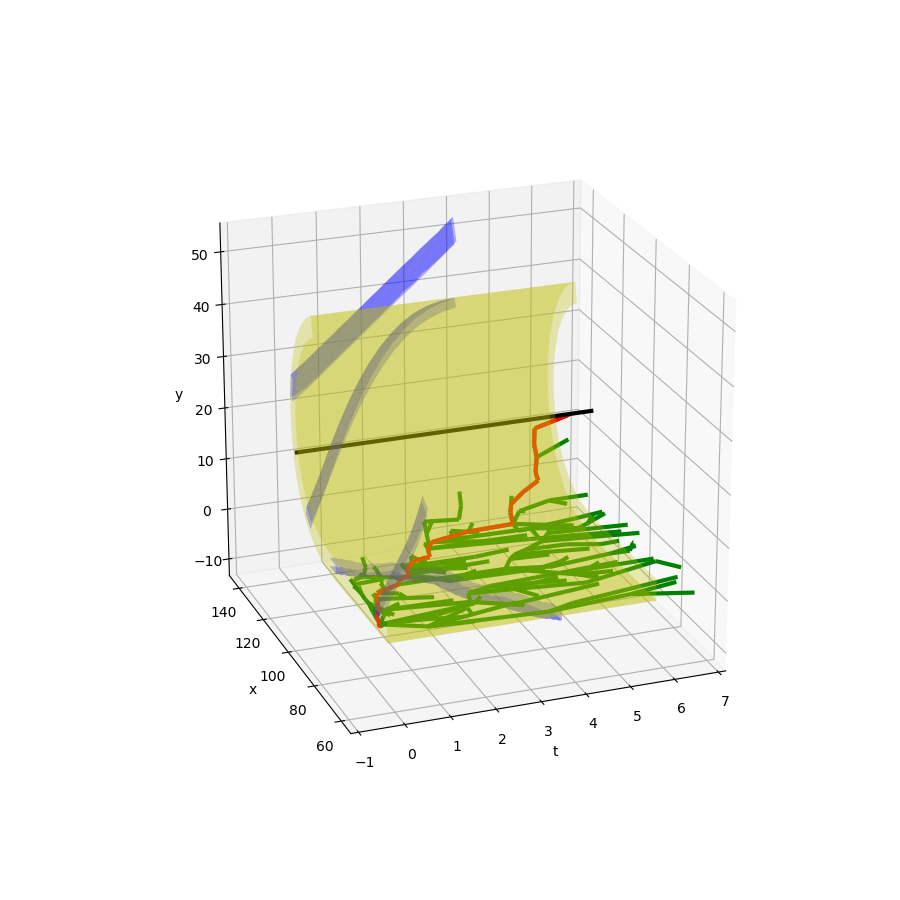

[  6.43156728 133.46532339  13.9753622 ]
IterationNum:  345
if Sucess:  True
cost time: 3.1385905742645264


In [31]:

WTimer = Timer()

fig = plt.figure()
ax = fig.gca(projection = '3d')


startPt = np.asarray([0, start_point_xy[0], start_point_xy[1]])
last_num = 30
endPt0 = np.asarray([0, ReferencePath[0][-last_num], ReferencePath[1][-last_num] - 2])
endPt1 = np.asarray([estimatedT + 2, ReferencePath[0][-last_num], ReferencePath[1][-last_num]-2])
PlotPoint3D(startPt, ax, color = 'r')
PlotLine3D([[endPt0, endPt1]], ax, color = 'k', linewidths=3)





lanePoly2D = []
region_s1 = [region_s[0]-5, region_s[1]+5] ## for use of test
for i in range(region_s1[0], region_s1[1]):
    lanePoly2D.append([inner_lane.x_set[i], inner_lane.y_set[i]])
for i in range(1, region_s1[1] - region_s1[0] + 1):
    lanePoly2D.append([outer_lane.x_set[region_s1[1]-i], outer_lane.y_set[region_s1[1]-i]])
    
lanePoly3D = [[0] + lanePoly2D[i] for i in range(len(lanePoly2D))]
lanePoly3D += [[estimatedT + 1] + lanePoly2D[i] for i in range(len(lanePoly2D))]

lanePolyNum = len(lanePoly2D)
lanePolyFaces = []
for i in range(lanePolyNum):
    if i == 0:
        lanePolyFaces.append([lanePolyNum-1, lanePolyNum-1 + lanePolyNum, 0 + lanePolyNum, 0])
    else:
        lanePolyFaces.append([i-1, i -1+ lanePolyNum, i + lanePolyNum, i])
        
lane3DBound = [[lanePoly3D[vertId] for vertId in face] for face in lanePolyFaces]


moving_object_set_polygon = []
moving_object_set_verts = []
for i in range(moving_object_num):
    moving_object_verts = []
    moving_object_faces = []
    for j in range(len(moving_object_set[i].trajectory.t_set)):
        if j != 0:
            startIndex = len(moving_object_verts)
            for k in range(3):
                moving_object_faces.append([startIndex + k, startIndex + 1+k, startIndex -3+k, startIndex - 4+k])
        moving_object_verts.extend([[moving_object_set[i].trajectory.t_set[j]] + list(moving_object_set[i].trajectoryPts[j][:, pointId]) for pointId in range(4)])
    moving_object_set_verts.append(moving_object_verts)
    moving_object_set_polygon.append([[moving_object_verts[vertId] for vertId in face] for face in moving_object_faces])

    
    
lanePoly2DArray = np.asarray(lanePoly2D)
minX = np.min(lanePoly2DArray[:,0])
maxX = np.max(lanePoly2DArray[:,0])
minY = np.min(lanePoly2DArray[:,1])
maxY = np.max(lanePoly2DArray[:,1])



branchLength = 3
pSet = [startPt]
pSetArray = np.asarray(pSet)
pSetParentIndex = [None]

probSamplingEnd = 0.2
iterationLoop = 1000
closeEpsilon = 0.001

validCount = 0
ifSucess = False
for _ in range(iterationLoop):
    if probSamplingEnd < np.random.random():
#         samplingP = SamplingInBound(searchBound)
#         samplingP = SamplingInPolygon(bound2D)

#         samplingP = SamplingInAny2DPolygon(lanePoly2D)
        tempS = np.random.random()*(region_s1[1] - region_s1[0]) + region_s1[0]
        tempL = np.random.random() * lane_width - lane_width / 2
        tempMidX = mid_lane.x_set[int(tempS)]
        tempMidY = mid_lane.y_set[int(tempS)]
        tempMidTheta = mid_lane.theta_set[int(tempS)]
        samplingP = [tempMidX + np.cos(np.pi/2 + tempMidTheta) * tempL, tempMidY + np.sin(np.pi/2 + tempMidTheta) * tempL]

        if samplingP is None:
            continue
            
        samplingP = np.asarray([np.random.random()*tRange] + list(samplingP))
    else:
        samplingP = np.asarray([np.random.random()*tRange] + list(endPt1[1:]))
    validCount += 1
#     print("valid count: ", validCount)
    formerIndex = np.where(pSetArray[:,0]<samplingP[0])[0]
    if formerIndex.shape[0] == 0:
        continue
    minIndexInValid = np.argmin(np.linalg.norm(pSetArray[formerIndex,:] - samplingP, axis=1))
    minIndex = formerIndex[minIndexInValid]
    branchP = LengthCut(pSet[minIndex], samplingP, branchLength, endPt1, criDim=[1,2], criL = 0.5)
    if not VerifyPointInPolygon(polygon=lanePoly2D, point=branchP[1:]):
        continue
#     if not IfInBound(branchP, bound):
#         continue
    for i in range(moving_object_num):
        if IfCollision3D([pSet[minIndex], branchP], moving_object_set_verts[i]):
            continue
    PlotLine3D([[pSet[minIndex], branchP]],ax,linewidths = 3)
#     PlotPoint3D(branchP, ax, color = 'g')
    pSetParentIndex.append(minIndex)
    pSet.append(branchP)
    pSetArray = np.asarray(pSet)
    if branchP[0] > tRange:
        print(pSet[minIndex], samplingP, branchP, endPt1)
    if IfEnd(branchP[1:], endPt1[1:], closeEpsilon):
        ifSucess = True
        break
        
print("IterationNum: ", validCount)
print("if Sucess: ", ifSucess)

if ifSucess:
    pathPIndex = PathPIndex(parentIndex=pSetParentIndex)
    pathPoint = PathPoint(pSet, pathPIndex)

    for i in range(len(pathPIndex)-1):
        PlotLine3D([[pathPoint[i], pathPoint[i+1]]],ax,linewidths = 3, color='r')



    
ax.set_xlabel('t')
ax.set_xlim3d(-1,tRange)
ax.set_ylabel('x')
ax.set_ylim3d(minX - 10,maxX+10)
ax.set_zlabel('y')
ax.set_zlim3d(minY-10,maxY+10)

ax.add_collection3d(Poly3DCollection(lane3DBound, facecolors = 'y', linewidths = 1, alpha = 0.3))
for i in range(len(moving_object_set_polygon)):
    ax.add_collection3d(Poly3DCollection(moving_object_set_polygon[i], facecolors = 'b', linewidths = 1, alpha = 0.3))
    
    
    
WTimer.TimeCostAndRenew()

The picture above shows the RRT in the space of $(x,y,t)$. The translucent yellow region is the lane. The blue regions are moving objects. The tree is green and the path is red. The black line is the goal position of the ego vehicle. It is a rough completion of the RRT (for example, I just let the 2-Norm of the branch be a constant which is not suitable because there are time and space variable in the space) but it is reasonable because I make sure that the tree grows along the direction of time increase.

<IPython.core.display.Javascript object>


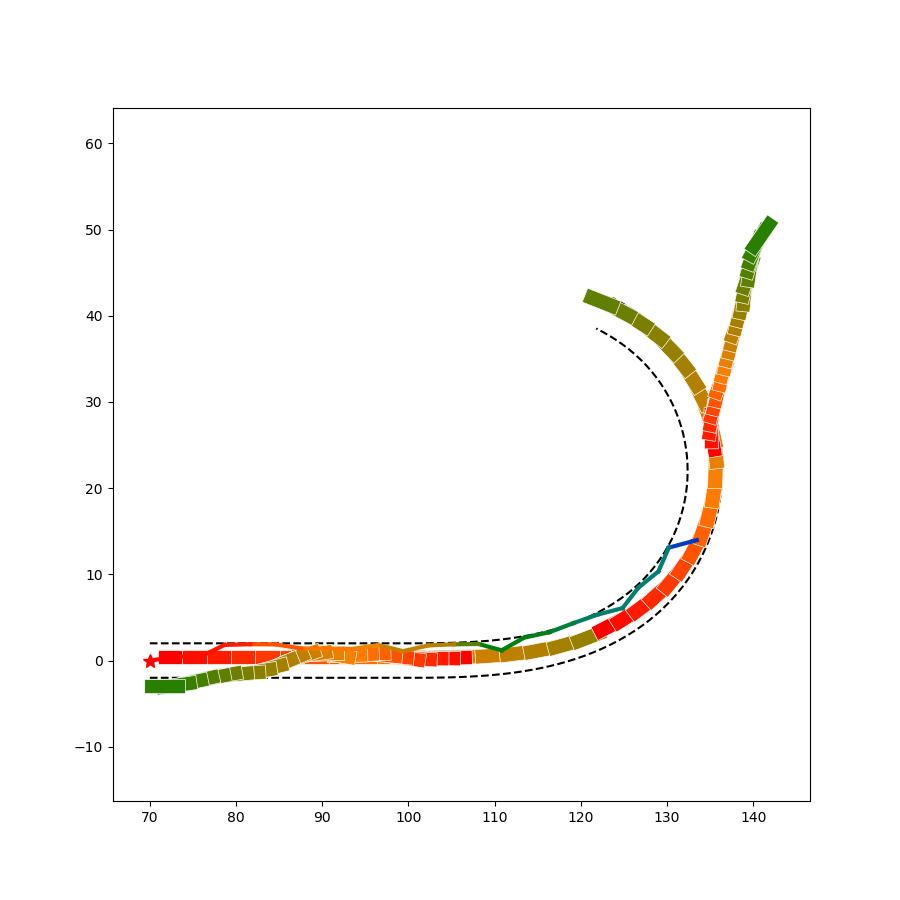

In [32]:
fig, ax = plt.subplots(1)

plt.plot(start_point_xy[0], start_point_xy[1],"r*", markersize = 10, zorder = 100000)
colors = [np.asarray([1,0,0]), np.asarray([1,0.5,0]), np.asarray([0.5,0.5,0]), np.asarray([0,0.5,0]), np.asarray([0,0.5,0.5]), np.asarray([0,0,1])]
valueColors = [i / (len(colors)-1) for i in range(len(colors))]


for mob in moving_object_set:
#     plt.plot(mob.pts[0,:], mob.pts[1,:], linewidth = 1, color = np.asarray([1,1,1])*0.3, zorder = 200)
    step = 3
    N = int(len(mob.trajectoryPts)/step)
    for i in range(N):
        index = step * i
        co = mob.trajectory.t_set[index]/tRange
        colorTemp = np.asarray([1,0,0])
        for j in range(len(colors)-1):
            if co >=valueColors[j] and co < valueColors[j+1]:
                colorTemp = (colors[j+1] * (co - valueColors[j]) + colors[j] * (valueColors[j+1] - co))*(len(colors)-1)
        a = PolyCollection([mob.trajectoryPts[index].transpose()], facecolors = colorTemp,linewidths=(0.5,),
                           edgecolors = 'w', zorder = 200)
        ax.add_collection(a)

        
pathPointArray = np.asarray(pathPoint)
for i in range(pathPointArray.shape[0]-1):
    co = pathPointArray[i,0] / tRange
    colorTemp = np.asarray([1,0,0])
    for j in range(len(colors)-1):
        if co >=valueColors[j] and co < valueColors[j+1]:
            colorTemp = (colors[j+1] * (co - valueColors[j]) + colors[j] * (valueColors[j+1] - co))*(len(colors)-1)
    plt.plot(pathPointArray[i:i+2,1], pathPointArray[i:i+2,2],color = colorTemp, linewidth = 3, zorder = 1000)        
        
        
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()  

#### Improvement of RRT
The RRT method above does not consider the kinematic properties and optimality. Here we will consider about these two essential respects in autopilot. 

One way is to generate smooth path directly, like Kinodynamic RRT*[1]. The problem here is that if we solve a time-consuming optimal control problem every time the tree grows a branch, efficiency will decrease.

Another common way is to generate the initial feasible path and then smooth it. The smooth method can be trajectory optimization problem with SQP, CFS[2] or other ways, in which variables are in the configuration space or control space. Actually, the postprocess can make the path satisfy the kinematic properties and increase optimiality, but currently, the result relies on the initial path too much. In other words, the smoothed path won't deviate from the initial one too much which limits the ability toward optimal point.

It should be noticed that related real application in current autopilot startups and companies which sperates the motion planning into lateral path planning and longitudinal speed planning is out of consideration because the decoupling will lead to deviate from global optimal more.

So here I explore a way in which the growth of branches satisfies the kinematic limitations. 

- **Define the length of each branch.** Setting 2-Norm of $p_i-p_j$, $p_i = (x_i,y_i,t_i)$, as a constant is not suitable. But we can set 2-Norm of $(x_i-x_j, y_i-y_j)$ (let this operate be $||\cdot||_2^{pos}$) as a constant $l_{branch}$.
- **How to choose the node in the tree closest to sampling node.** Connect sampling node $p_s$ and one of tree nodes $p_i$, we can get a virtual branch node $p_v$ ($||p_i-p_v||_2^{pos}=l_{branch}$). Then we can calculate the kinematic information, like velocity $v$, lateral and longitudinal (speed for convenience) acceleration $a$, curvature $\kappa$. The calculation are shown below and refer to previous content for the curvature calculation method *1)*. If the kinematic information exceedes the limitation, it is not feasible. Define the weighted sum of $v$, $a$ and $\kappa$ as distance, we can find the closest node among the whole feasible nodes.
  $$
  \begin{align}
  v &= \frac{l_{branch}}{t_v-t_i}\\
  a_s&= \frac{v-v_i}{t_v-t_i}\\
  a_l&= v^2\kappa
  \end{align}
  $$
- 


#### Reference 
[1] Webb, Dustin J., and Jur Van Den Berg. "Kinodynamic RRT*: Asymptotically optimal motion planning for robots with linear dynamics." 2013 IEEE international conference on robotics and automation. IEEE, 2013.

[2] Leu, Jessica, et al. "Efficient Robot Motion Planning via Sampling and Optimization." 2021 American Control Conference (ACC). IEEE, 2021.

## Section 2

<IPython.core.display.Javascript object>


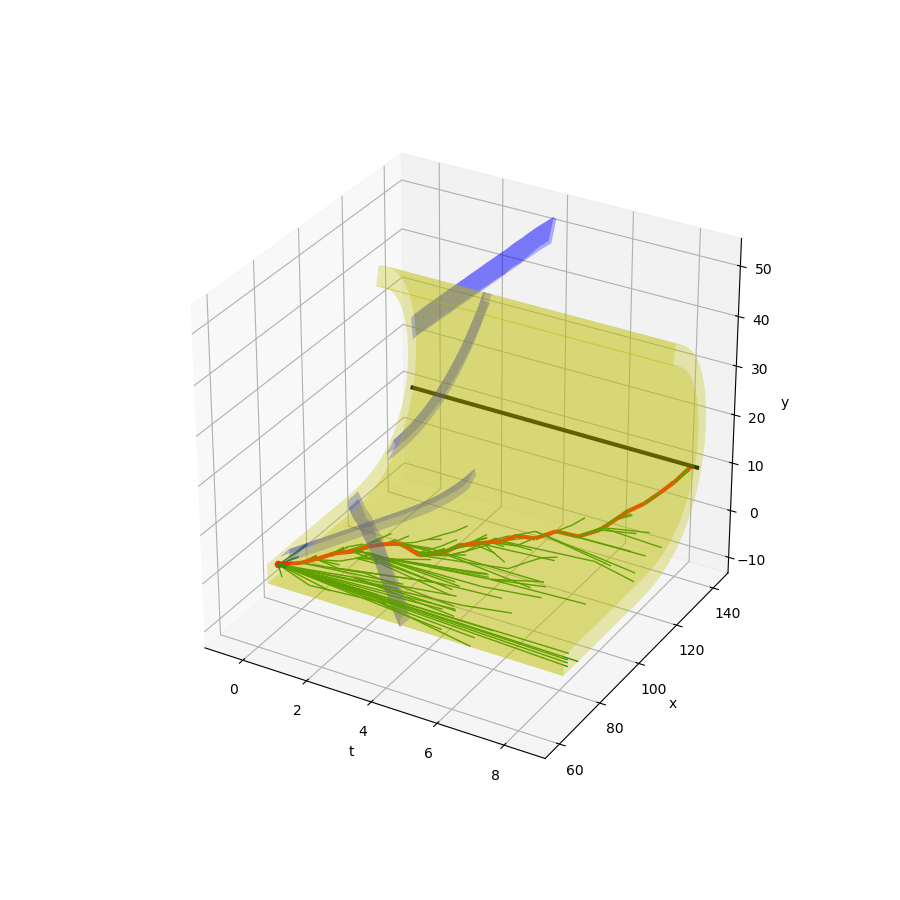

IterationNum:  371
if Sucess:  True
cost time: 4.786207437515259


In [40]:

WTimer = Timer()

fig = plt.figure()
ax = fig.gca(projection = '3d')

tRange = 9

startPt = np.asarray([0, start_point_xy[0], start_point_xy[1]])
last_num = 30
endPt0 = np.asarray([0, ReferencePath[0][-last_num], ReferencePath[1][-last_num] - 2])
endPt1 = np.asarray([tRange, ReferencePath[0][-last_num], ReferencePath[1][-last_num]-2])
PlotPoint3D(startPt, ax, color = 'r')
PlotLine3D([[endPt0, endPt1]], ax, color = 'k', linewidths=3)





lanePoly2D = []
region_s1 = [region_s[0]-5, region_s[1]+5] ## for use of test
for i in range(region_s1[0], region_s1[1]):
    lanePoly2D.append([inner_lane.x_set[i], inner_lane.y_set[i]])
for i in range(1, region_s1[1] - region_s1[0] + 1):
    lanePoly2D.append([outer_lane.x_set[region_s1[1]-i], outer_lane.y_set[region_s1[1]-i]])
    
lanePoly3D = [[0] + lanePoly2D[i] for i in range(len(lanePoly2D))]
lanePoly3D += [[tRange] + lanePoly2D[i] for i in range(len(lanePoly2D))]

lanePolyNum = len(lanePoly2D)
lanePolyFaces = []
for i in range(lanePolyNum):
    if i == 0:
        lanePolyFaces.append([lanePolyNum-1, lanePolyNum-1 + lanePolyNum, 0 + lanePolyNum, 0])
    else:
        lanePolyFaces.append([i-1, i -1+ lanePolyNum, i + lanePolyNum, i])
        
lane3DBound = [[lanePoly3D[vertId] for vertId in face] for face in lanePolyFaces]


moving_object_set_polygon = []
moving_object_set_verts = []
for i in range(moving_object_num):
    moving_object_verts = []
    moving_object_faces = []
    for j in range(len(moving_object_set[i].trajectory.t_set)):
        if j != 0:
            startIndex = len(moving_object_verts)
            for k in range(3):
                moving_object_faces.append([startIndex + k, startIndex + 1+k, startIndex -3+k, startIndex - 4+k])
        moving_object_verts.extend([[moving_object_set[i].trajectory.t_set[j]] + list(moving_object_set[i].trajectoryPts[j][:, pointId]) for pointId in range(4)])
    moving_object_set_verts.append(moving_object_verts)
    moving_object_set_polygon.append([[moving_object_verts[vertId] for vertId in face] for face in moving_object_faces])

    
    
lanePoly2DArray = np.asarray(lanePoly2D)
minX = np.min(lanePoly2DArray[:,0])
maxX = np.max(lanePoly2DArray[:,0])
minY = np.min(lanePoly2DArray[:,1])
maxY = np.max(lanePoly2DArray[:,1])



pSet = [startPt]
vSet = [25]
kappaSet = [0]
pSetArray = np.asarray(pSet)
pSetParentIndex = [None]

probSamplingEnd = 0.2
iterationLoop = 100000
closeEpsilon = 0.001

maxVelocity = 30
aSMax = 10
kappaMax = 0.5
aLMax = 10
branchL = 3


validCount = 0
ifSucess = False
for _ in range(iterationLoop):
    if probSamplingEnd < np.random.random():
#         samplingP = SamplingInBound(searchBound)
#         samplingP = SamplingInPolygon(bound2D)

#         samplingP = SamplingInAny2DPolygon(lanePoly2D)
        tempS = np.random.random()*(region_s1[1] - region_s1[0]) + region_s1[0]
        tempL = np.random.random() * lane_width - lane_width / 2
        tempMidX = mid_lane.x_set[int(tempS)]
        tempMidY = mid_lane.y_set[int(tempS)]
        tempMidTheta = mid_lane.theta_set[int(tempS)]
        samplingP = [tempMidX + np.cos(np.pi/2 + tempMidTheta) * tempL, tempMidY + np.sin(np.pi/2 + tempMidTheta) * tempL]

        if samplingP is None:
            continue
        
        minT = (tempS - region_s1[0]) / maxVelocity
        minT = 0
        samplingP = np.asarray([np.random.random()*(tRange-minT) + minT] + list(samplingP))
    else:
        minT = (region_s1[1] - region_s1[0])/maxVelocity
        minT = 0
        samplingP = np.asarray([np.random.random()*(tRange-minT) + minT] + list(endPt1[1:]))
    
#     print("valid count: ", validCount)
    formerIndex = np.where(pSetArray[:,0]<samplingP[0])[0]
    if formerIndex.shape[0] == 0:
        continue
        
    ######### 
    
    if np.linalg.norm(samplingP[1:] - endPt0[1:]) < 0.5:
        samplingP[1:] = endPt0[1:]
    
    
    tempValidID = []
    tempBranchPSet = []
    tempBranchVSet = []
    tempBranchKappaSet = []
    for tempID in formerIndex:
        ## check if too close
        p2 = (samplingP - pSet[tempID])
        tempBranchL = np.linalg.norm(p2[1:])
        if tempBranchL < 0.001 or p2[0] < 0.001:
            continue
            
        ## generate branch point roughly
        if np.linalg.norm(samplingP[1:] - endPt0[1:]) < 0.1 and np.linalg.norm(samplingP[1:] - pSet[tempID][1:]) < branchL:
            tempBranchP = samplingP # close to end point
        else:
            tempBranchP = p2 * branchL / tempBranchL + pSet[tempID] # pos dis
        tempBranchP[0] = min(tRange, tempBranchP[0]) # tRange

        # vector
        p2 = tempBranchP - pSet[tempID]
        tempBranchL = np.linalg.norm(p2[1:]) # pos dis
        sv2 = tempBranchL / p2[0] ## Point2 velocity
        flag = False
#         if sv2 > 16:
#             flag = True
#             print("sv2: ",sv2," samplingP: ", samplingP, " pSet: ", pSet[tempID])
        if tempID != 0:
            id1 = pSetParentIndex[tempID] ## Point1 ID
            p1 = pSet[tempID] - pSet[id1] 
            sv1 = vSet[tempID] ## Point1 velocity
            if np.linalg.norm(p1[1:]) < 0.001: # abnormal value
                continue
            kappa =  np.linalg.norm(p2[1:]/np.linalg.norm(p2[1:]) - p1[1:]/np.linalg.norm(p1[1:]))/np.linalg.norm(p1[1:]) ## curvature
            if kappa > kappaMax:
                continue
                
            # max Point2 velocity
            sv2Set = []
            if kappa > 0.001:
                sv2Set.append((aLMax / kappa)**0.5)
            sv2Set.append(maxVelocity)
            maxSv2 = min(sv2Set)
            
            aSv = [(max(0, sv1**2 - 2 * tempBranchL * aSMax))**0.5, (sv1**2 + 2 * tempBranchL * aSMax)**0.5]

            aSv[0] = max(1,aSv[0])

            if maxSv2 < aSv[0]:
                continue
            
            aSv[1] = min([maxSv2, aSv[1]])
            
            if sv2 < aSv[0]:
                sv2 = aSv[0]
                
            if sv2 > aSv[1]:
                sv2 = aSv[1]
                
#             print(sv2, aSv, tempBranchL)

            tempBranchP[0] = pSet[tempID][0] + np.linalg.norm(tempBranchL) / sv2            
            tempValidID.append(tempID)
            tempBranchPSet.append(tempBranchP)
            if flag:
                print(sv2, aSv, sv1, maxSv2)
            tempBranchVSet.append(sv2)
            tempBranchKappaSet.append(kappa)

        else:
            
#             sv2Set = []
#             sv2Set.append(maxVelocity)
#             maxSv2 = min(sv2Set)

#             sv1 = vSet[tempID] ## Point1 velocity

#             aSv = [max(0.1,sv1-aSMax*p1[0]),sv1+aSMax*p1[0]]

#             if maxSv2 < aSv[0]:
#                 continue

#             aSv[1] = min([maxSv2, aSv[1]])

#             if sv2 < aSv[0]:
#                 sv2 = aSv[0]

#             if sv2 > aSv[1]:
#                 sv2 = aSv[1]

            if sv2 <= maxVelocity:
                tempBranchP[0] = pSet[tempID][0] + np.linalg.norm(tempBranchL) / sv2            
                tempValidID.append(tempID)
                tempBranchPSet.append(tempBranchP)
                tempBranchVSet.append(sv2)
                if flag:
                    print(sv2, aSv, sv1)
                tempBranchKappaSet.append(0)



    if tempValidID == []:
        continue
        
    validCount += 1
    if validCount > 3000:
        break
        
        
        
        
        

    
#     collisionIDSet = []
#     for i in range(len(tempValidID)):
#         if not VerifyPointInPolygon(polygon=lanePoly2D, point=tempBranchPSet[i][1:]):
#             collisionIDSet.append(i)
#             continue
#         for j in range(moving_object_num):
#             if IfCollision3D([pSet[tempValidID[i]], tempBranchPSet[i]], moving_object_set_verts[j]):
#                 collisionIDSet.append(i)
#                 continue
#     #     minIndexInValid = np.random.randint(0,len(tempValidID))
#     tempBranchPSetArray = np.asarray(tempBranchPSet)
#     minIndexInValid = -1
#     minDis = 1000000
#     for i in range(len(tempValidID)):
#         if i not in collisionIDSet:
#             tempDis = np.linalg.norm(tempBranchPSetArray[i, 1:] - samplingP[1:])
#             if tempDis < minDis:
#                 minDis = tempDis
#                 minIndexInValid = i
#     if minIndexInValid < 0:
#         continue
#     minIndex = tempValidID[minIndexInValid]
#     branchP = tempBranchPSet[minIndexInValid]
#     branchV = tempBranchVSet[minIndexInValid]
#     branchKappa = tempBranchKappaSet[minIndexInValid]
    
    
    
    tempBranchPSetArray = np.asarray(tempBranchPSet)
    minIndexInValid = np.argmin(np.linalg.norm(tempBranchPSetArray[:,1:] - samplingP[1:], axis=1))
    minIndex = tempValidID[minIndexInValid]
    branchP = tempBranchPSet[minIndexInValid]
    branchV = tempBranchVSet[minIndexInValid]
    branchKappa = tempBranchKappaSet[minIndexInValid]
    if not VerifyPointInPolygon(polygon=lanePoly2D, point=branchP[1:]):
        continue
    for i in range(moving_object_num):
        if IfCollision3D([pSet[minIndex], branchP], moving_object_set_verts[i]):
            continue
            
            
            
            
                
                
    PlotLine3D([[pSet[minIndex], branchP]],ax,linewidths = 1)
#     PlotPoint3D(branchP, ax, color = 'g')
    pSetParentIndex.append(minIndex)
    pSet.append(branchP)
    vSet.append(branchV)
    kappaSet.append(branchKappa)
    pSetArray = np.asarray(pSet)
#     if branchP[0] > tRange:
#         print("wrong.")
#         print(tempBranchPSet)
#         print("point")
#         print("pSet: ",pSet[minIndex], " sampling: ",samplingP, " branch: ",branchP, sv2)
#         break
    if IfEnd(branchP[1:], endPt1[1:], closeEpsilon):
        ifSucess = True
        break

        
print("IterationNum: ", validCount)
print("if Sucess: ", ifSucess)

if True:
    pathPIndex = PathPIndex(parentIndex=pSetParentIndex)
    pathPoint = PathPoint(pSet, pathPIndex)

    for i in range(len(pathPIndex)-1):
        PlotLine3D([[pathPoint[i], pathPoint[i+1]]],ax,linewidths = 3, color='r')



    
ax.set_xlabel('t')
ax.set_xlim3d(-1,tRange)
ax.set_ylabel('x')
ax.set_ylim3d(minX - 10,maxX+10)
ax.set_zlabel('y')
ax.set_zlim3d(minY-10,maxY+10)

ax.add_collection3d(Poly3DCollection(lane3DBound, facecolors = 'y', linewidths = 1, alpha = 0.3))
for i in range(len(moving_object_set_polygon)):
    ax.add_collection3d(Poly3DCollection(moving_object_set_polygon[i], facecolors = 'b', linewidths = 1, alpha = 0.3))
    
    
    
WTimer.TimeCostAndRenew()

<IPython.core.display.Javascript object>


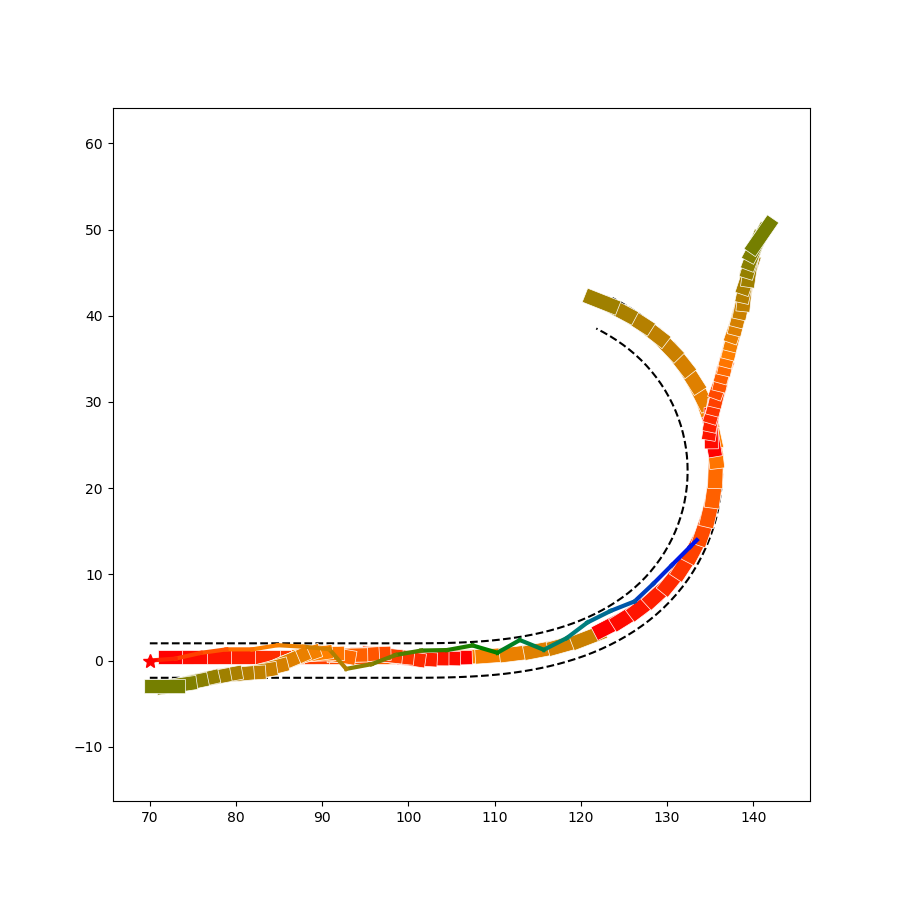

In [41]:
fig, ax = plt.subplots(1)

plt.plot(start_point_xy[0], start_point_xy[1],"r*", markersize = 10, zorder = 100000)
colors = [np.asarray([1,0,0]), np.asarray([1,0.5,0]), np.asarray([0.5,0.5,0]), np.asarray([0,0.5,0]), np.asarray([0,0.5,0.5]), np.asarray([0,0,1])]
valueColors = [i / (len(colors)-1) for i in range(len(colors))]


for mob in moving_object_set:
#     plt.plot(mob.pts[0,:], mob.pts[1,:], linewidth = 1, color = np.asarray([1,1,1])*0.3, zorder = 200)
    step = 3
    N = int(len(mob.trajectoryPts)/step)
    for i in range(N):
        index = step * i
        co = mob.trajectory.t_set[index]/tRange
        colorTemp = np.asarray([1,0,0])
        for j in range(len(colors)-1):
            if co >=valueColors[j] and co < valueColors[j+1]:
                colorTemp = (colors[j+1] * (co - valueColors[j]) + colors[j] * (valueColors[j+1] - co))*(len(colors)-1)
        a = PolyCollection([mob.trajectoryPts[index].transpose()], facecolors = colorTemp,linewidths=(0.5,),
                           edgecolors = 'w', zorder = 200)
        ax.add_collection(a)

        
pathPointArray = np.asarray(pathPoint)
for i in range(pathPointArray.shape[0]-1):
    co = pathPointArray[i,0] / tRange
    colorTemp = np.asarray([1,0,0])
    for j in range(len(colors)-1):
        if co >=valueColors[j] and co < valueColors[j+1]:
            colorTemp = (colors[j+1] * (co - valueColors[j]) + colors[j] * (valueColors[j+1] - co))*(len(colors)-1)
    plt.plot(pathPointArray[i:i+2,1], pathPointArray[i:i+2,2],color = colorTemp, linewidth = 3, zorder = 1000)        
        
        
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()  

In [42]:
def PFindMinDis2Bound(p, bound):
    disList = list(np.linalg.norm(bound - p, axis = 1))
    index = disList.index(min(disList))
    closestP = bound[index,:]
    return [abs(p[0]-closestP[0]), abs(p[1]-closestP[1])]

def VertAtT(tempT, verts):
    polygon = []
    for j in range(int(len(verts)/4)-1):
        index = 4*j
        if verts[index][0]<= tempT and verts[index + 4][0]>= tempT:
            co = (tempT - verts[index][0]) / (verts[index+4][0] - verts[index][0])
            for k in range(4):
                polygon.append([verts[index + k][m]+co*(verts[index+k+4][m]-verts[index+k][m]) for m in range(1,3)])
            break
    return polygon

def PFindMinDis2Object(p,vertsList):
    ptsAtT = []
    for i in range(len(vertsList)):
        ptsAtT.extend(VertAtT(p[0], vertsList[i]))
    if ptsAtT == []:
        return [None, None]
    pArray = np.asarray(p)
    ptsAtTArray = np.asarray(ptsAtT)
    
    return PFindMinDis2Bound(pArray[1:], ptsAtTArray)

def BoundAtT(p,vertsList):
    ptsAtT = []
    for i in range(len(vertsList)):
        ptsAtT.extend(VertAtT(p[0], vertsList[i]))
    return ptsAtT


class edge:
    def __init__(self, edgeId, length, p, adjacentId, operator):
        self.id = edgeId
        self.length = length
        self.p = p
        self.adjacentId = adjacentId
        self.operator = operator
    def plot(self):
        plt.plot([self.p[0][0], self.p[1][0]], [self.p[0][1], self.p[1][1]])
        
        
        
def CheckPinPoly(p, polygon):
    count = 0
    for i in range(polygon.shape[0]-1):
        p1 = polygon[i,:]
        p2 = polygon[i+1,:]
        inBound1 = (p[0] >= p1[0]) and (p[0] < p2[0])
        inBound2 = (p[0] >= p2[0]) and (p[0] < p1[0])
        if (inBound1 or inBound2) and (p1[1] + (p2[1] - p1[1])/(p2[0] - p1[0])*(p[0] - p1[0]) >= p[1]):
            count += 1
    if count % 2 == 0:
        return False
    else:
        return True
    
def GenRectPts(p, w,h):
    x,y = p
    return [[x - w/2, y-h/2],[x+w/2, y-h/2],[x+w/2,y+h/2],[x-w/2,y+h/2]]

def ClosedObstacleAtT(p,vertsList):
    ptsAtT = []
    for i in range(len(vertsList)):
        notClosedOb = VertAtT(p[0], vertsList[i])
        if notClosedOb != []:
            ptsAtT.append(notClosedOb + [notClosedOb[0]])
    return ptsAtT

class edge:
    def __init__(self, edgeId, length, p, adjacentId, operator):
        self.id = edgeId
        self.length = length
        self.p = p
        self.adjacentId = adjacentId
        self.operator = operator
    def plot(self):
        plt.plot([self.p[0][0], self.p[1][0]], [self.p[0][1], self.p[1][1]])

def GenBound(centerP, inPolygon = None, outPolygonSet = None, growDis = 1, iterTime = 40, show = False):
    pSet = [copy.deepcopy(centerP) for _ in range(4)]
    edgeSet = []
    pIdSet = [[3,0],[0,1],[1,2],[2,3]]
    adjacentIdSet = [[3,1],[0,2],[1,3],[2,0]]
    operatorSet = [[0,-1],[1,-1],[0,1],[1,1]]

    for i in range(4):
        edgeSet.append(edge(i, 2, [pSet[j] for j in pIdSet[i]], adjacentIdSet[i],operatorSet[i]))

    idIter = 0

    for k in range(40):
        growDis = 1
        maxLen = None
        maxLenId = None
        idIter = edgeSet[idIter].adjacentId[1]
        for _ in range(4):
            tempE = edgeSet[idIter]
            tempEdgeP = [copy.deepcopy(tempE.p[0]),copy.deepcopy(tempE.p[1])]
            operator = tempE.operator
            for j in range(2):
                tempEdgeP[j][operator[0]] += operator[1]*growDis
            
            inFlag = True
            outFlag = True
            if inPolygon is not None:
                inFlag = CheckPinPoly(tempEdgeP[0], inPolygon) and CheckPinPoly(tempEdgeP[1], inPolygon)
            if outPolygonSet is not None:
                for outPolygon in outPolygonSet:
                    outFlag &= (not CheckPinPoly(tempEdgeP[0], outPolygon)) and (not CheckPinPoly(tempEdgeP[1], outPolygon))
            if inFlag and outFlag:
                if maxLen is None:
                    maxLen = tempE.length
                    maxLenId = idIter
                else:
                    if tempE.length > maxLen:
                        maxLen = tempE.length
                        maxLenId = idIter
                        
            idIter = edgeSet[idIter].adjacentId[1]
                
        if maxLen is None:
            idIter = edgeSet[idIter].adjacentId[1]
            break
        currentE = edgeSet[maxLenId]
        operator = currentE.operator
        for i in range(2):
            currentE.p[i][operator[0]] += operator[1]*growDis

        edgeSet[currentE.adjacentId[0]].p[1] = currentE.p[0]
        edgeSet[currentE.adjacentId[1]].p[0] = currentE.p[1]
        edgeSet[currentE.adjacentId[0]].length += growDis
        edgeSet[currentE.adjacentId[1]].length += growDis

        idIter = maxLenId
    #     for _ in range(4):
    #         edgeSet[idIter].plot()
    #         idIter = edgeSet[idIter].adjacentId[1]



    if show:
        fig, ax = plt.subplots(1)
        for _ in range(4):
            edgeSet[idIter].plot()
            idIter = edgeSet[idIter].adjacentId[1]
        plt.plot(inPolygon[:,0], inPolygon[:,1], label = 'bound')
        plt.plot(outPolygon[:,0], outPolygon[:,1], label = 'obstacle')

        plt.scatter(centerP[0],centerP[1],label = 'point in rectangle')
        plt.axis('equal')
        plt.legend()
        plt.show()
        
    bound = []
    bound.append(edgeSet[0].p[0][0])
    bound.append(edgeSet[2].p[0][0])
    bound.append(edgeSet[1].p[0][1])
    bound.append(edgeSet[3].p[0][1])
    return bound #[xmin, xmax, ymin,ymax]

In [43]:
closedLanePoly2D = lanePoly2D + [lanePoly2D[0]]
closedLanePoly2DArray = np.asarray(closedLanePoly2D)

In [51]:
x0 = [] # [x1,x2,x3,...,xn, y1,y2,y3,...yn]
timeSet = [] # [t1,t2,t3,...]
for p in pathPoint:
    x0.append(p[1])
    timeSet.append(p[0])

for p in pathPoint:
    x0.append(p[2])
    
tSet = [] # [t2-t1, t3-t2,...]
for i in range(len(pathPoint)-1):
    tSet.append(pathPoint[i+1][0] - pathPoint[i][0])
    
numOfPoint = len(pathPoint)
newPathPoint = copy.deepcopy(pathPoint)
newPathPointArray = np.asarray(newPathPoint)

last_fun = 0
for iter in range(20):
    
    x0 = [] # [x1,x2,x3,...,xn, y1,y2,y3,...yn]
    for p in newPathPoint:
        x0.append(p[1])

    for p in newPathPoint:
        x0.append(p[2])

    ## velocity
    maxVelocityX = 30 # success 10000
    maxVelocityY = 30


    velocityA = np.zeros(shape = (2*(numOfPoint-1), 2*numOfPoint))
    lbVelocity = []
    ubVelocity = []
    for i in range(numOfPoint-1):
        velocityA[i,i] = -1 / tSet[i]
        velocityA[i, i+1] = 1 / tSet[i]
        lbVelocity.append(-maxVelocityX)
        ubVelocity.append(maxVelocityX)

    for i in range(numOfPoint-1):
        velocityA[i+numOfPoint-1,i+numOfPoint] = -1 / tSet[i]
        velocityA[i+numOfPoint-1, i+1+numOfPoint] = 1 / tSet[i]
        lbVelocity.append(-maxVelocityY)
        ubVelocity.append(maxVelocityY)


    ## acc
    maxAccX = 20
    maxAccY = 20
    accA = np.zeros(shape = (2*(numOfPoint-2), 2*numOfPoint))
    lbAcc = []
    ubAcc = []
    for i in range(numOfPoint-2):
        accA[i,i] = 1 / tSet[i]/(tSet[i+1] + tSet[i])*2
        accA[i, i+1] = -1 / tSet[i]/tSet[i+1]*2
        accA[i, i+2] = 1 / tSet[i+1]/(tSet[i+1] + tSet[i])*2
        lbAcc.append(-maxAccX)
        ubAcc.append(maxAccX)

    for i in range(numOfPoint-2):
        accA[i+numOfPoint-2,i+numOfPoint] = 1 / tSet[i]/(tSet[i+1] + tSet[i])*2
        accA[i+numOfPoint-2, i+1+numOfPoint] = -1 / tSet[i]/tSet[i+1]*2
        accA[i+numOfPoint-2, i+2+numOfPoint] = 1 / tSet[i+1]/(tSet[i+1] + tSet[i])*2
        lbAcc.append(-maxAccY)
        ubAcc.append(maxAccY)

    ## Bound
    bnds = [[None,None] for _ in range(2*numOfPoint)]
    closedLanePoly2D = lanePoly2D + [lanePoly2D[0]]
    closedLanePoly2DArray = np.asarray(closedLanePoly2D)
    for i in range(numOfPoint):
        tempT = timeSet[i]
        obstacles = ClosedObstacleAtT(newPathPointArray[i,:], moving_object_set_verts)
        obstacles = [np.asarray(ob) for ob in obstacles]
        piBound = GenBound(newPathPointArray[i,1:], inPolygon = closedLanePoly2DArray, outPolygonSet = obstacles, growDis = 0.2, iterTime = 40, show = False)
        bnds[i] = [piBound[0], piBound[1]]
        bnds[i + numOfPoint] = [piBound[2], piBound[3]]
        
#         addBound = BoundAtT(newPathPointArray[i,:], moving_object_set_verts)
#         newBound = lanePoly2D + addBound
#         FD = PFindMinDis2Bound(newPathPointArray[i,1:],np.asarray(newBound))
#         if i == numOfPoint - 6:
#             print(FD, newPathPointArray[i,1:])
#         if FD[0] is not None:
#             bnds[i] = [newPathPointArray[i,1] - FD[0], newPathPointArray[i,1] + FD[0]]
#         if FD[1] is not None:
#             bnds[i + numOfPoint] = [newPathPointArray[i,2] - FD[1], newPathPointArray[i,2] + FD[1]]




    ## target
    targetX = endPt0[1]
    targetY = endPt0[2]



    # constrained QP

    def opt_fun_y(x):
        tsum = 0
        for i in range(numOfPoint):
            tsum -= 1/((x[i] - targetX)**2/10000 + 1)

        for i in range(numOfPoint):
            tsum -= 1/((x[i+numOfPoint] - targetY)**2/10000 + 1)

        return tsum

    def opt_jac_y(x):
        tsum = []
        for i in range(numOfPoint):
            tsum.append(2 * (x[i]-targetX)/10000/((x[i] - targetX)**2/10000 + 1)**2)
        for i in range(numOfPoint):
            tsum.append(2 * (x[i+numOfPoint]-targetY)/10000/((x[i+numOfPoint] - targetY)**2/10000 + 1)**2)
        return tsum


    opt_cons = ({'type': 'eq', 'fun': lambda x:  x[numOfPoint-1]-x0[numOfPoint-1]},{'type': 'eq', 'fun': lambda x:  x[-1]-x0[-1]},
                optimize.LinearConstraint(velocityA, lbVelocity, ubVelocity), optimize.LinearConstraint(accA, lbAcc, ubAcc))
    
#     opt_cons = ({'type': 'eq', 'fun': lambda x:  x[numOfPoint-1]-x0[numOfPoint-1]},{'type': 'eq', 'fun': lambda x:  x[-1]-x0[-1]},
#             optimize.LinearConstraint(velocityA, lbVelocity, ubVelocity), )

#     opt_cons = ({'type': 'eq', 'fun': lambda x:  x[numOfPoint-1]-x0[numOfPoint-1]},{'type': 'eq', 'fun': lambda x:  x[-1]-x0[-1]})

    resY = optimize.minimize(opt_fun_y, x0,method = "SLSQP", jac = opt_jac_y, constraints = opt_cons, 
                             bounds=bnds,options = {'disp': True})
    
    print(resY.x[numOfPoint-1], resY.x[-1])
    
    newPathPoint = []
    for i in range(numOfPoint):
        newPathPoint.append([timeSet[i], resY.x[i], resY.x[i+numOfPoint]])
        
    newPathPointArray = np.asarray(newPathPoint)
    
    if abs(last_fun - resY.fun) < 0.001:
        break
    
    last_fun = resY.fun

Optimization terminated successfully    (Exit mode 0)
            Current function value: -47.74099143032245
            Iterations: 63
            Function evaluations: 63
            Gradient evaluations: 63
70.0 0.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -47.895862271357174
            Iterations: 48
            Function evaluations: 48
            Gradient evaluations: 48
70.0 0.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -48.00605497939277
            Iterations: 41
            Function evaluations: 41
            Gradient evaluations: 41
70.0 0.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -48.081623716058814
            Iterations: 43
            Function evaluations: 43
            Gradient evaluations: 43
70.0 0.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -48.14781278153819
            I

<IPython.core.display.Javascript object>


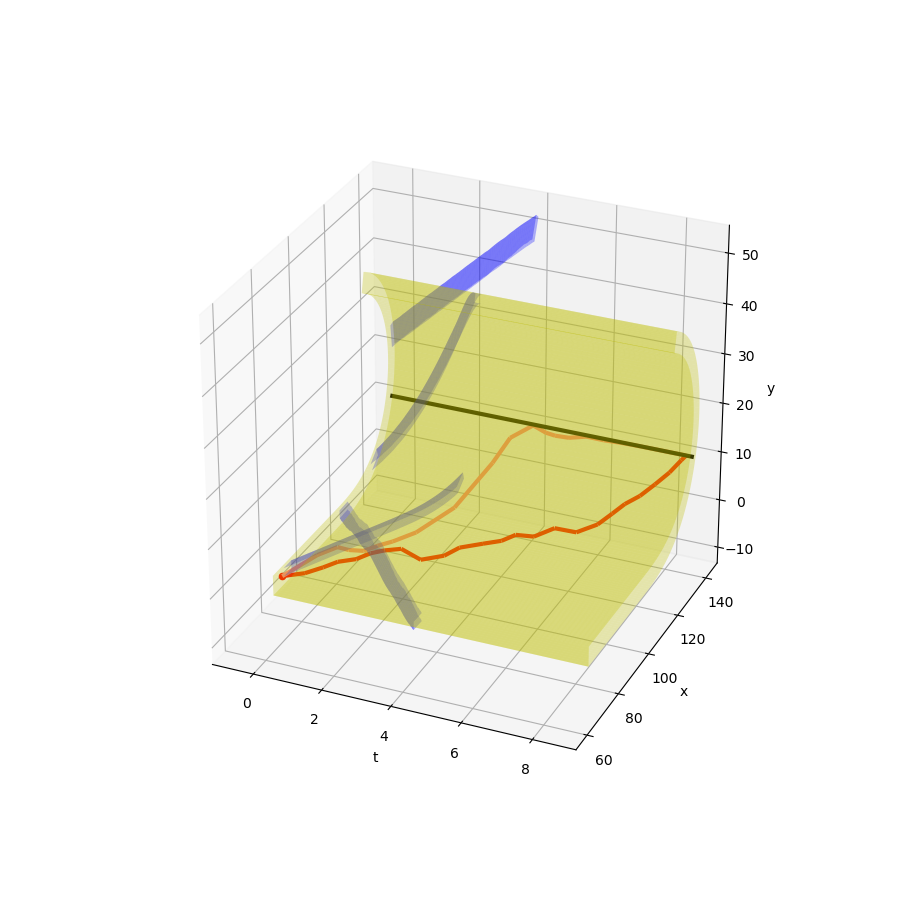

In [52]:

fig = plt.figure()
ax = fig.gca(projection = '3d')

PlotPoint3D(startPt, ax, color = 'r')
PlotLine3D([[endPt0, endPt1]], ax, color = 'k', linewidths=3)

for i in range(len(pathPIndex)-1):
    PlotLine3D([[pathPoint[i], pathPoint[i+1]]],ax,linewidths = 3, color='r')
    PlotLine3D([[newPathPoint[i], newPathPoint[i+1]]],ax,linewidths = 3, color=[1,0.5,0.5])


    
ax.set_xlabel('t')
ax.set_xlim3d(-1,tRange)
ax.set_ylabel('x')
ax.set_ylim3d(minX - 10,maxX+10)
ax.set_zlabel('y')
ax.set_zlim3d(minY-10,maxY+10)

ax.add_collection3d(Poly3DCollection(lane3DBound, facecolors = 'y', linewidths = 1, alpha = 0.3))
for i in range(len(moving_object_set_polygon)):
    ax.add_collection3d(Poly3DCollection(moving_object_set_polygon[i], facecolors = 'b', linewidths = 1, alpha = 0.3))
    
    
    
    

<IPython.core.display.Javascript object>


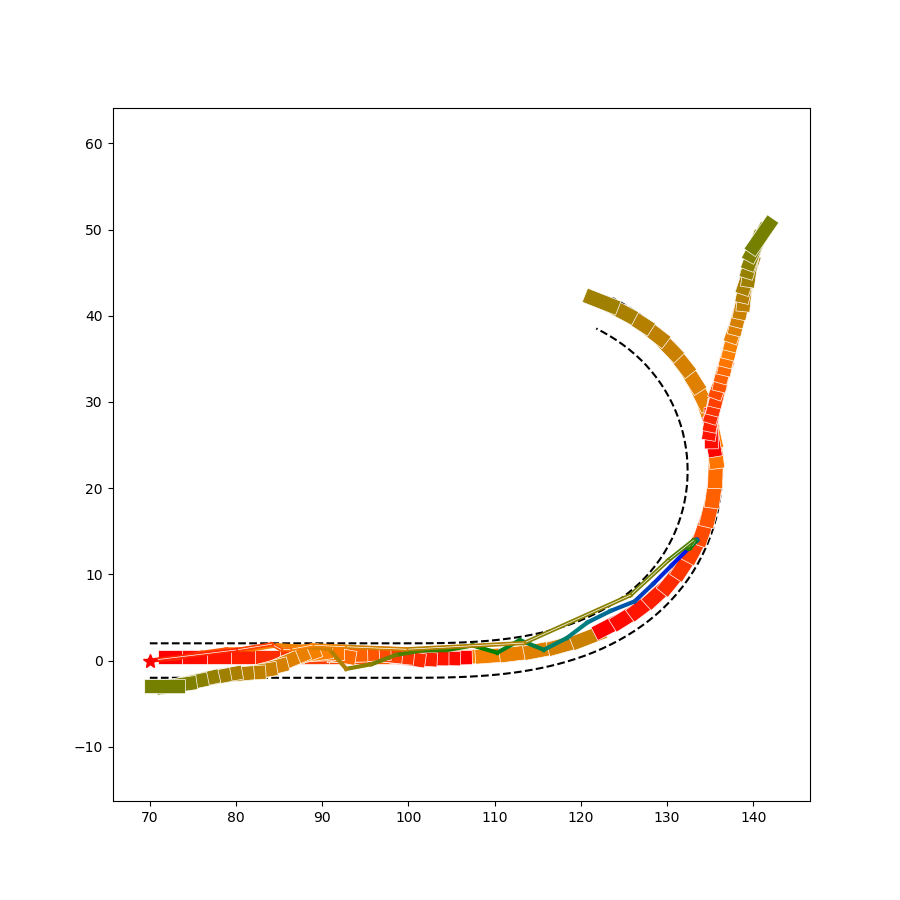

In [53]:
fig, ax = plt.subplots(1)

plt.plot(start_point_xy[0], start_point_xy[1],"r*", markersize = 10, zorder = 100000)
colors = [np.asarray([1,0,0]), np.asarray([1,0.5,0]), np.asarray([0.5,0.5,0]), np.asarray([0,0.5,0]), np.asarray([0,0.5,0.5]), np.asarray([0,0,1])]
valueColors = [i / (len(colors)-1) for i in range(len(colors))]


for mob in moving_object_set:
#     plt.plot(mob.pts[0,:], mob.pts[1,:], linewidth = 1, color = np.asarray([1,1,1])*0.3, zorder = 200)
    step = 3
    N = int(len(mob.trajectoryPts)/step)
    for i in range(N):
        index = step * i
        co = mob.trajectory.t_set[index]/tRange
        colorTemp = np.asarray([1,0,0])
        for j in range(len(colors)-1):
            if co >=valueColors[j] and co < valueColors[j+1]:
                colorTemp = (colors[j+1] * (co - valueColors[j]) + colors[j] * (valueColors[j+1] - co))*(len(colors)-1)
        a = PolyCollection([mob.trajectoryPts[index].transpose()], facecolors = colorTemp,linewidths=(0.5,),
                           edgecolors = 'w', zorder = 200)
        ax.add_collection(a)

        
pathPointArray = np.asarray(pathPoint)
for i in range(pathPointArray.shape[0]-1):
    co = pathPointArray[i,0] / tRange
    colorTemp = np.asarray([1,0,0])
    for j in range(len(colors)-1):
        if co >=valueColors[j] and co < valueColors[j+1]:
            colorTemp = (colors[j+1] * (co - valueColors[j]) + colors[j] * (valueColors[j+1] - co))*(len(colors)-1)
    plt.plot(pathPointArray[i:i+2,1], pathPointArray[i:i+2,2],color = colorTemp, linewidth = 3, zorder = 1000)        
    
newPathPointArray = np.asarray(newPathPoint)
for i in range(newPathPointArray.shape[0]-1):
    co = newPathPointArray[i,0] / tRange
    colorTemp = np.asarray([1,0,0])
    for j in range(len(colors)-1):
        if co >=valueColors[j] and co < valueColors[j+1]:
            colorTemp = (colors[j+1] * (co - valueColors[j]) + colors[j] * (valueColors[j+1] - co))*(len(colors)-1)
    plt.plot(newPathPointArray[i:i+2,1], newPathPointArray[i:i+2,2],color = colorTemp, linewidth = 3, zorder = 1000)        
    plt.plot(newPathPointArray[i:i+2,1], newPathPointArray[i:i+2,2],color = [1,1,1], linewidth = 0.5, zorder = 1000)        

        
        
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()  

## Section 3

<IPython.core.display.Javascript object>


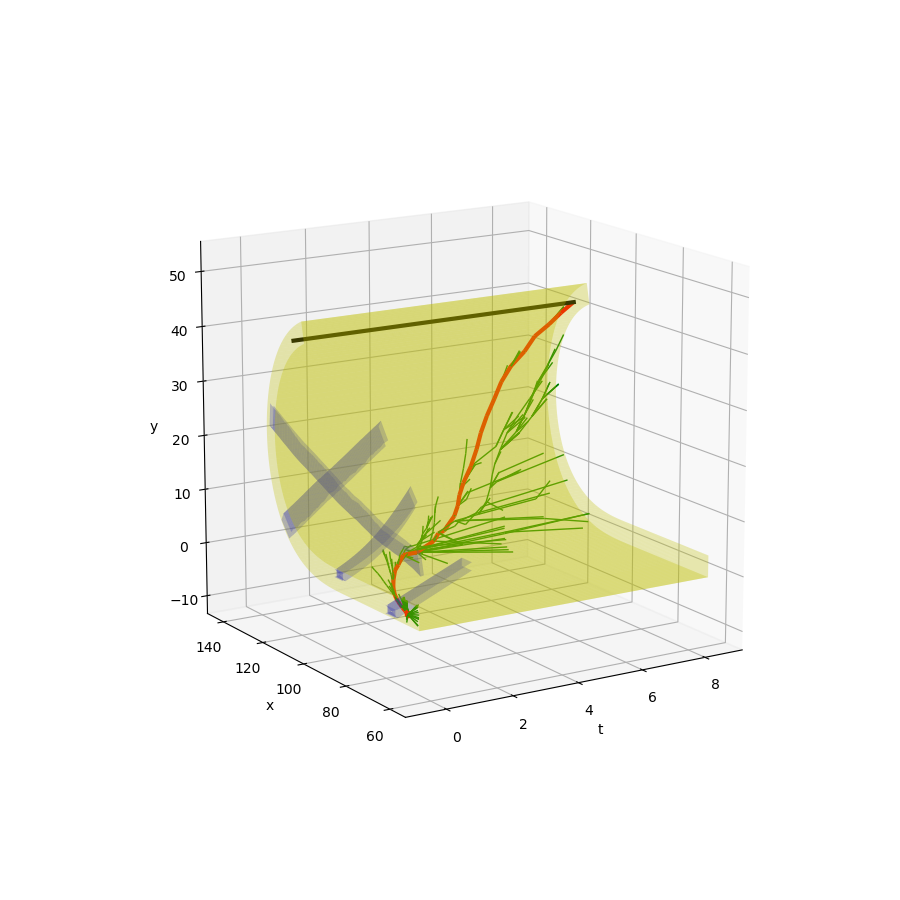

IterationNum:  831
if Sucess:  True
cost time: 7.9704649448394775


In [47]:

WTimer = Timer()

fig = plt.figure()
ax = fig.gca(projection = '3d')

tRange = 9

startPt = np.asarray([0, start_point_xy[0], start_point_xy[1]])
endPt0 = np.asarray([0, ReferencePath[0][-1], ReferencePath[1][-1] - 2])
endPt1 = np.asarray([tRange, ReferencePath[0][-1], ReferencePath[1][-1]-2])
PlotPoint3D(startPt, ax, color = 'r')
PlotLine3D([[endPt0, endPt1]], ax, color = 'k', linewidths=3)





lanePoly2D = []
region_s1 = [region_s[0]-5, region_s[1]+5] ## for use of test
for i in range(region_s1[0], region_s1[1]):
    lanePoly2D.append([inner_lane.x_set[i], inner_lane.y_set[i]])
for i in range(1, region_s1[1] - region_s1[0] + 1):
    lanePoly2D.append([outer_lane.x_set[region_s1[1]-i], outer_lane.y_set[region_s1[1]-i]])
    
lanePoly3D = [[0] + lanePoly2D[i] for i in range(len(lanePoly2D))]
lanePoly3D += [[tRange] + lanePoly2D[i] for i in range(len(lanePoly2D))]

lanePolyNum = len(lanePoly2D)
lanePolyFaces = []
for i in range(lanePolyNum):
    if i == 0:
        lanePolyFaces.append([lanePolyNum-1, lanePolyNum-1 + lanePolyNum, 0 + lanePolyNum, 0])
    else:
        lanePolyFaces.append([i-1, i -1+ lanePolyNum, i + lanePolyNum, i])
        
lane3DBound = [[lanePoly3D[vertId] for vertId in face] for face in lanePolyFaces]


moving_object_set_polygon = []
moving_object_set_verts = []
for i in range(moving_object_num):
    moving_object_verts = []
    moving_object_faces = []
    for j in range(len(moving_object_set[i].trajectory.t_set)):
        if j != 0:
            startIndex = len(moving_object_verts)
            for k in range(3):
                moving_object_faces.append([startIndex + k, startIndex + 1+k, startIndex -3+k, startIndex - 4+k])
        moving_object_verts.extend([[moving_object_set[i].trajectory.t_set[j]] + list(moving_object_set[i].trajectoryPts[j][:, pointId]) for pointId in range(4)])
    moving_object_set_verts.append(moving_object_verts)
    moving_object_set_polygon.append([[moving_object_verts[vertId] for vertId in face] for face in moving_object_faces])

    
    
lanePoly2DArray = np.asarray(lanePoly2D)
minX = np.min(lanePoly2DArray[:,0])
maxX = np.max(lanePoly2DArray[:,0])
minY = np.min(lanePoly2DArray[:,1])
maxY = np.max(lanePoly2DArray[:,1])



pSet = [startPt]
vSet = [25]
kappaSet = [0]
pSetArray = np.asarray(pSet)
pSetParentIndex = [None]

probSamplingEnd = 0.2
iterationLoop = 100000
closeEpsilon = 0.001

maxVelocity = 30
aSMax = 10
kappaMax = 0.5
aLMax = 10
branchL = 3


validCount = 0
ifSucess = False
for _ in range(iterationLoop):
    if probSamplingEnd < np.random.random():
#         samplingP = SamplingInBound(searchBound)
#         samplingP = SamplingInPolygon(bound2D)

#         samplingP = SamplingInAny2DPolygon(lanePoly2D)
        tempS = np.random.random()*(region_s1[1] - region_s1[0]) + region_s1[0]
        tempL = np.random.random() * lane_width - lane_width / 2
        tempMidX = mid_lane.x_set[int(tempS)]
        tempMidY = mid_lane.y_set[int(tempS)]
        tempMidTheta = mid_lane.theta_set[int(tempS)]
        samplingP = [tempMidX + np.cos(np.pi/2 + tempMidTheta) * tempL, tempMidY + np.sin(np.pi/2 + tempMidTheta) * tempL]

        if samplingP is None:
            continue
        
        minT = (tempS - region_s1[0]) / maxVelocity
        minT = 0
        samplingP = np.asarray([np.random.random()*(tRange-minT) + minT] + list(samplingP))
    else:
        minT = (region_s1[1] - region_s1[0])/maxVelocity
        minT = 0
        samplingP = np.asarray([np.random.random()*(tRange-minT) + minT] + list(endPt1[1:]))
    
#     print("valid count: ", validCount)
    formerIndex = np.where(pSetArray[:,0]<samplingP[0])[0]
    if formerIndex.shape[0] == 0:
        continue
        
    ######### 
    
    if np.linalg.norm(samplingP[1:] - endPt0[1:]) < 0.5:
        samplingP[1:] = endPt0[1:]
        
        
    minIndexInValid = np.argmin(np.linalg.norm(pSetArray[formerIndex,1:] - samplingP[1:], axis=1))
    minIndex = formerIndex[minIndexInValid]
    
    tempID = minIndex
    p2 = (samplingP - pSet[tempID])
    tempBranchL = np.linalg.norm(p2[1:])
    if tempBranchL < 0.001 or p2[0] < 0.001:
        continue

    ## generate branch point roughly
    if np.linalg.norm(samplingP[1:] - endPt0[1:]) < 0.1 and np.linalg.norm(samplingP[1:] - pSet[tempID][1:]) < branchL:
        tempBranchP = samplingP # close to end point
    else:
        tempBranchP = p2 * branchL / tempBranchL + pSet[tempID] # pos dis
    tempBranchP[0] = min(tRange, tempBranchP[0]) # tRange

    # vector
    p2 = tempBranchP - pSet[tempID]
    tempBranchL = np.linalg.norm(p2[1:]) # pos dis
    sv2 = tempBranchL / p2[0] ## Point2 velocity
    if tempID != 0:
        id1 = pSetParentIndex[tempID] ## Point1 ID
        p1 = pSet[tempID] - pSet[id1] 
        sv1 = vSet[tempID] ## Point1 velocity
        if np.linalg.norm(p1[1:]) < 0.001: # abnormal value
            continue
        kappa =  np.linalg.norm(p2[1:]/np.linalg.norm(p2[1:]) - p1[1:]/np.linalg.norm(p1[1:]))/np.linalg.norm(p1[1:]) ## curvature
        if kappa > kappaMax:
            continue

        # max Point2 velocity
        sv2Set = []
        if kappa > 0.001:
            sv2Set.append((aLMax / kappa)**0.5)
        sv2Set.append(maxVelocity)
        maxSv2 = min(sv2Set)

        aSv = [(max(0, sv1**2 - 2 * tempBranchL * aSMax))**0.5, (sv1**2 + 2 * tempBranchL * aSMax)**0.5]

        aSv[0] = max(1,aSv[0])

        if maxSv2 < aSv[0]:
            continue

        aSv[1] = min([maxSv2, aSv[1]])

        if sv2 < aSv[0]:
            sv2 = aSv[0]

        if sv2 > aSv[1]:
            sv2 = aSv[1]

        tempBranchP[0] = pSet[tempID][0] + np.linalg.norm(tempBranchL) / sv2            
    else:

        sv2Set = []
        sv2Set.append(maxVelocity)
        maxSv2 = min(sv2Set)

        sv1 = vSet[tempID] ## Point1 velocity

        aSv = [max(0.1,sv1-aSMax*p1[0]),sv1+aSMax*p1[0]]

        if maxSv2 < aSv[0]:
            continue

        aSv[1] = min([maxSv2, aSv[1]])

        if sv2 < aSv[0]:
            sv2 = aSv[0]

        if sv2 > aSv[1]:
            sv2 = aSv[1]

        if sv2 <= maxVelocity:
            tempBranchP[0] = pSet[tempID][0] + np.linalg.norm(tempBranchL) / sv2            
            kappa = 0
        else:
            continue



    if tempValidID == []:
        continue
        
    validCount += 1
    if validCount > 3000:
        break
    
    
    branchP = tempBranchP
    branchV = sv2
    branchKappa = kappa
    
    if not VerifyPointInPolygon(polygon=lanePoly2D, point=branchP[1:]):
        continue
    for i in range(moving_object_num):
        if IfCollision3D([pSet[minIndex], branchP], moving_object_set_verts[i]):
            continue
            
            
            
            
                
                
    PlotLine3D([[pSet[minIndex], branchP]],ax,linewidths = 1)
#     PlotPoint3D(branchP, ax, color = 'g')
    pSetParentIndex.append(minIndex)
    pSet.append(branchP)
    vSet.append(branchV)
    kappaSet.append(branchKappa)
    pSetArray = np.asarray(pSet)
#     if branchP[0] > tRange:
#         print("wrong.")
#         print(tempBranchPSet)
#         print("point")
#         print("pSet: ",pSet[minIndex], " sampling: ",samplingP, " branch: ",branchP, sv2)
    if IfEnd(branchP[1:], endPt1[1:], closeEpsilon):
        ifSucess = True
        break

        
print("IterationNum: ", validCount)
print("if Sucess: ", ifSucess)

if True:
    pathPIndex = PathPIndex(parentIndex=pSetParentIndex)
    pathPoint = PathPoint(pSet, pathPIndex)

    for i in range(len(pathPIndex)-1):
        PlotLine3D([[pathPoint[i], pathPoint[i+1]]],ax,linewidths = 3, color='r')



    
ax.set_xlabel('t')
ax.set_xlim3d(-1,tRange)
ax.set_ylabel('x')
ax.set_ylim3d(minX - 10,maxX+10)
ax.set_zlabel('y')
ax.set_zlim3d(minY-10,maxY+10)

ax.add_collection3d(Poly3DCollection(lane3DBound, facecolors = 'y', linewidths = 1, alpha = 0.3))
for i in range(len(moving_object_set_polygon)):
    ax.add_collection3d(Poly3DCollection(moving_object_set_polygon[i], facecolors = 'b', linewidths = 1, alpha = 0.3))
    
    
    
WTimer.TimeCostAndRenew()

<IPython.core.display.Javascript object>


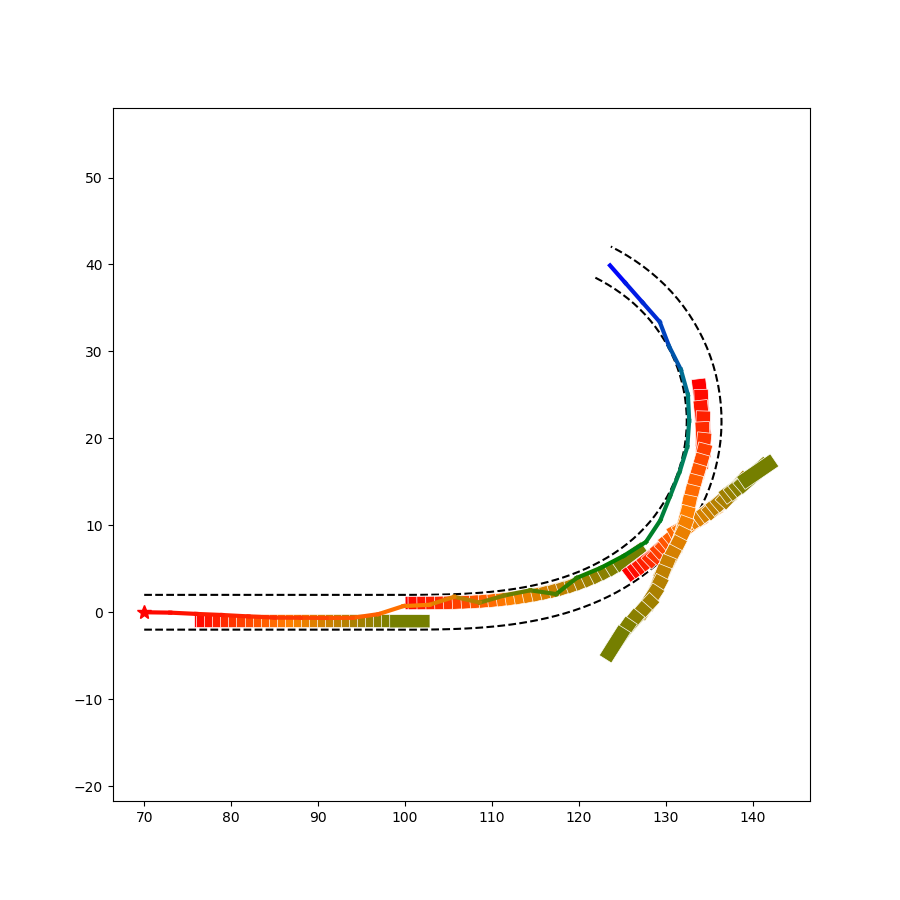

In [48]:
fig, ax = plt.subplots(1)

plt.plot(start_point_xy[0], start_point_xy[1],"r*", markersize = 10, zorder = 100000)
colors = [np.asarray([1,0,0]), np.asarray([1,0.5,0]), np.asarray([0.5,0.5,0]), np.asarray([0,0.5,0]), np.asarray([0,0.5,0.5]), np.asarray([0,0,1])]
valueColors = [i / (len(colors)-1) for i in range(len(colors))]


for mob in moving_object_set:
#     plt.plot(mob.pts[0,:], mob.pts[1,:], linewidth = 1, color = np.asarray([1,1,1])*0.3, zorder = 200)
    step = 3
    N = int(len(mob.trajectoryPts)/step)
    for i in range(N):
        index = step * i
        co = mob.trajectory.t_set[index]/tRange
        colorTemp = np.asarray([1,0,0])
        for j in range(len(colors)-1):
            if co >=valueColors[j] and co < valueColors[j+1]:
                colorTemp = (colors[j+1] * (co - valueColors[j]) + colors[j] * (valueColors[j+1] - co))*(len(colors)-1)
        a = PolyCollection([mob.trajectoryPts[index].transpose()], facecolors = colorTemp,linewidths=(0.5,),
                           edgecolors = 'w', zorder = 200)
        ax.add_collection(a)

        
pathPointArray = np.asarray(pathPoint)
for i in range(pathPointArray.shape[0]-1):
    co = pathPointArray[i,0] / tRange
    colorTemp = np.asarray([1,0,0])
    for j in range(len(colors)-1):
        if co >=valueColors[j] and co < valueColors[j+1]:
            colorTemp = (colors[j+1] * (co - valueColors[j]) + colors[j] * (valueColors[j+1] - co))*(len(colors)-1)
    plt.plot(pathPointArray[i:i+2,1], pathPointArray[i:i+2,2],color = colorTemp, linewidth = 3, zorder = 1000)        
        
        
plt.plot(inner_lane.x_set[region_s[0]: region_s[1]], inner_lane.y_set[region_s[0]: region_s[1]], 'k--')
plt.plot(outer_lane.x_set[region_s[0]: region_s[1]], outer_lane.y_set[region_s[0]: region_s[1]],'k--')
plt.axis('equal')
plt.show()  